In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ing-hackathon-data/sample_submission.csv
/kaggle/input/ing-hackathon-data/referance_data.csv
/kaggle/input/ing-hackathon-data/referance_data_test.csv
/kaggle/input/ing-hackathon-data/customers.csv
/kaggle/input/ing-hackathon-data/customer_history.csv


## FUNCTIONS

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np


def recall_at_k(y_true, y_prob, k=0.1):
    """
    Tahmin edilen olasılıkların en üst k%'sını pozitif etiketleyerek recall değerini hesaplar.

    Parametreler:
        y_true (list): Gerçek ikili etiketler.
        y_prob (list): Tahmin edilen olasılıklar.
        k (float): Pozitif etiketlenecek olasılıkların yüzdelik dilimi (varsayılan 0.1).

    Döndürür:
        float: En iyi k% tahminlerindeki recall oranı.
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]

    tp_at_k = y_true[top].sum()
    P = y_true.sum()

    return float(tp_at_k / P) if P > 0 else 0.0


def lift_at_k(y_true, y_prob, k=0.1):
    """
    Tahmin edilen olasılıkların en üst k%'sını pozitif etiketleyerek lift (precision/prevalence) değerini hesaplar.

    Parametreler:
        y_true (list): Gerçek ikili etiketler.
        y_prob (list): Tahmin edilen olasılıklar.
        k (float): Pozitif etiketlenecek olasılıkların yüzdelik dilimi (varsayılan 0.1).

    Döndürür:
        float: En iyi k% tahminlerindeki lift değeri.
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]

    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()

    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0


def convert_auc_to_gini(auc):
    """
    ROC AUC skorunu Gini katsayısına dönüştürür.

    Gini katsayısı, ROC AUC skorunun doğrusal bir dönüşümüdür.

    Parametreler:
        auc (float): ROC AUC skoru (0 ile 1 arasında).

    Döndürür:
        float: Gini katsayısı (-1 ile 1 arasında).
    """
    return 2 * auc - 1


def ing_hubs_datathon_metric(y_true, y_prob):
    """
    Gini, recall@10% ve lift@10% metriklerini birleştiren özel bir metrik hesaplar.

    Metrik, her bir skoru bir baseline modelin metrik değerlerine göre oranlar ve aşağıdaki ağırlıkları uygular:
    - Gini: %40
    - Recall@10%: %30
    - Lift@10%: %30

    Parametreler:
        y_true (list): Gerçek ikili etiketler.
        y_prob (list): Tahmin edilen olasılıklar.

    Döndürür:
        float: Ağırlıklandırılmış bileşik skor.
    """
    # final metrik için ağırlıklar
    score_weights = {
        "gini": 0.4,
        "recall_at_10perc": 0.3,
        "lift_at_10perc": 0.3,
    }

    # baseline modelin her bir metrik için değerleri
    baseline_scores = {
        "roc_auc": 0.6925726757936908,
        "recall_at_10perc": 0.18469015795868773,
        "lift_at_10perc": 1.847159286784029,
    }

    # y_prob tahminleri için metriklerin hesaplanması
    roc_auc = roc_auc_score(y_true, y_prob)
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {
        "roc_auc": roc_auc,
        "recall_at_10perc": recall_at_10perc,
        "lift_at_10perc": lift_at_10perc,
    }

    # roc auc değerlerinin gini değerine dönüştürülmesi
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])

    # baseline modeline oranlama
    final_gini_score = new_scores["gini"] / baseline_scores["gini"]
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"]
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"]

    # ağırlıklandırılmış metriğin hesaplanması
    final_score = (
        final_gini_score * score_weights["gini"] +
        final_recall_score * score_weights["recall_at_10perc"] + 
        final_lift_score * score_weights["lift_at_10perc"]
    )
    return final_score


## Understanding of the Data with EDA

In [ ]:
customer_history = pd.read_csv("/kaggle/input/ing-hackathon-data/customer_history.csv")
customers = pd.read_csv("/kaggle/input/ing-hackathon-data/customers.csv")
reference_data= pd.read_csv("/kaggle/input/ing-hackathon-data/referance_data.csv")
reference_data_test = pd.read_csv("/kaggle/input/ing-hackathon-data/referance_data_test.csv")
sample_submission = pd.read_csv("/kaggle/input/ing-hackathon-data/sample_submission.csv")

print("📊 VERİ SETİ BOYUTLARI:")
print(f"customer_history: {customer_history.shape}")
print(f"customers: {customers.shape}")
print(f"reference_data: {reference_data.shape}")
print(f"reference_data_test: {reference_data_test.shape}")
print(f"sample_submission: {sample_submission.shape}")

Assumptions-Ideas : Tenure - Retention should be correlated. Possible idea that retired people naturally will pass away so the churn posibility should be much higher then the other work groups, possible students should have a behouvior to be churn.

Customers may tend to reduce their usage of products before churning.

The risk of churn of the customer are the fact that the salary card belongs in another bank in. (Define a feature that mirror this effect) 


In [ ]:
# impute work type feature with semantic imputation
customers.loc[customers['work_type'] == 'Student', 'work_sector'] = 'Dependent'
customers.loc[customers['work_type'] == 'Unemployed', 'work_sector'] = 'Unemployed'
customers.loc[customers['work_type'] == 'Retired', 'work_sector'] = 'Pension'


In [ ]:
# work_sector distribution
plt.figure(figsize=(10,6))
sns.countplot(data=customers, x='work_sector', order=customers['work_sector'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Work Sector')
plt.ylabel('Count')
plt.xlabel('Work Sector')
plt.show()


In [ ]:
# work_type distribution
plt.figure(figsize=(8,6))
sns.countplot(data=customers, x='work_type', order=customers['work_type'].value_counts().index, palette='Set2')
plt.title('Distribution of Work Type')
plt.xlabel('Work Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


As an inference, we can say that actively earning money leads to using a bank's products, which is expected. ING bank should also capture the self-employed attention. The number of self-employed customer is lower then the other working groups.

In [ ]:
# tenure distribution by work type
plt.figure(figsize=(10,6))
sns.boxplot(data=customers, x='work_type', y='tenure', palette='Set3')
plt.title('Tenure Distribution by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Tenure (months)')
plt.xticks(rotation=45)
plt.show()


Overall, we can infer from this graph that customer tenure (the length of time someone has been a customer) tends to increase with age and financial stability. The tenure for individuals in the unemployed category is lower than for the working groups but is still significant. This could imply that customers do not immediately end their banking relationship upon losing a job, or that they had already been customers for a considerable time before becoming unemployed.

In [ ]:
# tenure distribution by work_sector
plt.figure(figsize=(12,6))
sns.boxplot(data=customers, x='work_sector', y='tenure', palette='Set3')
plt.title('Tenure Distribution by Work Sector')
plt.xlabel('Work Sector')
plt.ylabel('Tenure (months)')
plt.xticks(rotation=45)
plt.show()


This suggests that once a customer is established in their professional life, the specific type of sector they work in has little impact on their loyalty or tenure with the bank. A tech employee and an educator have similarly long-standing relationships with their bank. These groups form the stable, core customer base.

In [ ]:
# tenure dist by religion
plt.figure(figsize=(12,6))
sns.boxplot(data=customers, x='religion', y='tenure', palette='Set2')
plt.title('Tenure Distribution by Religion')
plt.xlabel('Religion')
plt.ylabel('Tenure (months)')
plt.xticks(rotation=45)
plt.show()


There is no correlation between religion and tenure here.

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=customers, x='province', y='tenure', palette='Set3')
plt.title('Tenure Distribution by Province')
plt.xlabel('Province')
plt.ylabel('Tenure (months)')
plt.xticks(rotation=45)
plt.show()


There is no correlation between the tenure and the province.

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=customers, x='age', y='tenure', alpha=0.6)
plt.title('Tenure vs Age')
plt.xlabel('Age')
plt.ylabel('Tenure (months)')
plt.show()


The most obvious takeaway is the strong positive correlation between age and tenure. As a customer's age increases, their potential tenure with the bank also increases. This visually confirms why the "Pensioner/Retired" group in the previous box plots had the highest tenure. The sharp, linear edge on the upper-left side of the data cloud is very significant. This line represents the maximum possible tenure for any given age. The dots along this boundary are the "lifelong loyal" customers—those who joined the bank at a young age (likely 18-20) and have never left. For instance, a 40-year-old customer can have a maximum tenure of 240 months (20 years), which aligns perfectly with this line.

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=customers, x='work_sector', y='tenure', hue='gender', palette='Set3')
plt.title('Tenure by Work Sector and Gender')
plt.xlabel('Work Sector')
plt.ylabel('Tenure (months)')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()


Some of the gender related graphics has been deleted and no proof that find there is a relation between the gender and tenure.

## DATA PREPROCESSING

In [ ]:
# merge customer_history and reference_date tables
customer_history_reference_data = customer_history.merge(reference_data, on='cust_id', how='inner')
customer_history_reference_data.head(5)

In [ ]:
customer_history_reference_data.isnull().sum()

#customer_history_reference_data[customer_history_reference_data["cust_id"]==0]

In [ ]:
# Identify customers who have credit cards and those who use EFT, meaning they have deposit accounts
customer_history_reference_data['has_cc'] = np.where(customer_history_reference_data['cc_transaction_all_cnt'].notna(), 1, 0)
customer_history_reference_data['has_eft'] = np.where(customer_history_reference_data['mobile_eft_all_cnt'].notna(), 1, 0)


In [ ]:
# Unique values for has_eft and has_cc
customer_history_reference_data.groupby(['has_eft','has_cc'])['cust_id'].nunique()


In [ ]:
# There is no significant evidence having a credit card or not, or having a eft.
churn_summary = (
    customer_history_reference_data
    .groupby(['has_eft', 'has_cc'])['churn']
    .mean()
    .reset_index()
)
churn_summary

Merge customers and customer_history_reference_data, all information will be in the same data

In [ ]:
cust_hist_ref_df.head(10)

In [ ]:
cust_hist_ref_df = customer_history_reference_data.merge(customers, on='cust_id', how='inner')
cust_hist_ref_df.head(5)

In [ ]:
# Impute null values as 0 (we keep the information about the nulls already)
cust_hist_ref_df = cust_hist_ref_df.fillna(0)
cust_hist_ref_df.head()


In [ ]:
# Change dates as datetime
cust_hist_ref_df['date'] = pd.to_datetime(cust_hist_ref_df['date'])
cust_hist_ref_df['ref_date'] = pd.to_datetime(cust_hist_ref_df['ref_date'])

# Smaller dates 
cust_hist_ref_df = cust_hist_ref_df[cust_hist_ref_df['date'] < cust_hist_ref_df['ref_date']]


## FEATURE ENGINEERING

In [ ]:
summary_df = cust_hist_ref_df.groupby(['cust_id', 'ref_date']).agg(
    avg_eft_cnt = ('mobile_eft_all_cnt', 'mean'),
    avg_eft_amt = ('mobile_eft_all_amt', 'mean'),
    avg_cc_amt = ('cc_transaction_all_amt', 'mean'),
    avg_cc_cnt = ('cc_transaction_all_cnt', 'mean'),
    avg_active_products = ('active_product_category_nbr', 'mean'),
    has_cc = ('has_cc', 'max'),
    has_eft = ('has_eft', 'max'),
    gender = ('gender', 'first'),
    age = ('age', 'first'),
    province = ('province', 'first'),
    religion = ('religion', 'first'),
    work_type = ('work_type', 'first'),
    work_sector = ('work_sector', 'first'),
    tenure = ('tenure', 'first'),
    churn = ('churn', 'first')  # hedef değişken
).reset_index()

In [ ]:
summary_df.head(15)

In [ ]:
# Age distribution by Churn
plt.figure(figsize=(10,6))
sns.histplot(data=summary_df, x="age", hue="churn", multiple="stack", bins=20)
plt.title("Age dağılımı - Churn Durumu")
plt.xlabel("Age")
plt.ylabel("Müşteri Sayısı")
plt.show()

This indicates that middle-aged customers have the highest propensity to churn. Customers in this age range are often making major financial decisions (e.g., mortgages, investments, children's education). Consequently, they may be more open to switching banks for better offers or services. It is critically important for the bank to focus its retention efforts primarily on this segment. This confirms once again that older customers are the most loyal segment. The churn rate in this group is very low. This finding is perfectly consistent with the high tenure data we saw in the previous graphs. Younger customers generally exhibit a loyal profile. This group represents both current stability and future potential for the bank.

In [ ]:
summary_df['age_group'] = summary_df['age'].apply(categorize_age)
summary_df.head()

In [ ]:
# Provice by Churn
plt.figure(figsize=(12,6))
sns.countplot(data=summary_df, x="province", hue="churn")
plt.title("Province bazında Churn Sayıları")
plt.xlabel("Province")
plt.ylabel("Müşteri Sayısı")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=summary_df, x="religion", hue="churn")
plt.title("Religion bazında Churn Sayıları")
plt.xlabel("Religion")
plt.ylabel("Müşteri Sayısı")
plt.xticks(rotation=45)
plt.show()


The fact that 'U' is the largest category often represents cases where this information was "Unspecified" or "Unknown," which is common in such datasets. The other letters ('C', 'I', 'M', 'O') likely represent specific faith groups ("Christian," "Jewish/Islamic," "Muslim," "Other"). a customer's religious affiliation does not influence their decision to leave the bank. It would be far more effective for the bank to focus its resources and attention on segmentations that have a real impact on churn, such as age and province, as we identified in the previous analyses

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=summary_df, x="churn", y="tenure")
plt.title("Churn durumuna göre Tenure dağılımı")
plt.xlabel("Churn")
plt.ylabel("Tenure")
plt.show()

## EVALUATION DATA PREPROCESSING

In [ ]:
reference_data

In [ ]:
customer_history_reference_data_eva = customer_history.merge(reference_data, on='cust_id', how='inner')
customer_history_reference_data_eva.head(5)

In [ ]:
# Identify customers who have credit cards and those who use EFT, meaning they have deposit accounts
customer_history_reference_data_eva['has_cc'] = np.where(customer_history_reference_data_eva['cc_transaction_all_cnt'].notna(), 1, 0)
customer_history_reference_data_eva['has_eft'] = np.where(customer_history_reference_data_eva['mobile_eft_all_cnt'].notna(), 1, 0)


In [ ]:
cust_hist_ref_df_eva = customer_history_reference_data_eva.merge(customers, on='cust_id', how='inner')
cust_hist_ref_df_eva.head(5)

In [ ]:
cust_hist_ref_df_eva = cust_hist_ref_df_eva.fillna(0)


In [ ]:
cust_hist_ref_df_eva['date'] = pd.to_datetime(cust_hist_ref_df_eva['date'])
cust_hist_ref_df_eva['ref_date'] = pd.to_datetime(cust_hist_ref_df_eva['ref_date'])

In [ ]:
cust_hist_ref_df_eva.head()

In [ ]:
filtered_df = cust_hist_ref_df_eva[cust_hist_ref_df_eva['ref_date'] == cust_hist_ref_df_eva['date']]
filtered_df.head()

In [ ]:
filtered_df['age_group'] = filtered_df['age'].apply(categorize_age)
filtered_df.head()

In [ ]:
column_mapping = {
    'mobile_eft_all_cnt': 'avg_eft_cnt',
    'mobile_eft_all_amt': 'avg_eft_amt',
    'cc_transaction_all_amt': 'avg_cc_amt',
    'cc_transaction_all_cnt': 'avg_cc_cnt',
    'active_product_category_nbr': 'avg_active_products'
}

# Sütun isimlerini değiştir
filtered_df = filtered_df.rename(columns=column_mapping)
filtered_df.head()

In [ ]:
filtered_df = filtered_df.drop(columns=['date'])
filtered_df.head()

In [ ]:
filtered_df = filtered_df[summary_df.columns]

In [ ]:
summary_df.head()


In [ ]:
filtered_df.head()

In [ ]:
filtered_df.head()

## MODEL

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Data
target = 'churn'
drop_cols = ['cust_id', 'ref_date', target]

X_train = summary_df.drop(columns=drop_cols)
y_train = summary_df[target]

X_eval = filtered_df.drop(columns=drop_cols)
y_eval = filtered_df[target]

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Optuna objective (hızlı versiyon)
def objective(trial):
    params = {
        "iterations": 500,  # daha kısa
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth": trial.suggest_int("depth", 4, 9),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 5, log=True),
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": 0,
        "early_stopping_rounds": 30,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_eval, y_eval), use_best_model=True)
    
    y_pred_prob = model.predict_proba(X_eval)[:,1]
    auc = roc_auc_score(y_eval, y_pred_prob)
    return auc

# Hızlı Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)  # 10 trial ile hızlı

print("Best Params:", study.best_params)
print("Best CV AUC:", study.best_value)

# Final model
best_params = study.best_params
best_params.update({"iterations": 500, "eval_metric": "AUC", "random_seed": 42, "verbose": 100})
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_eval, y_eval), use_best_model=True)

# Prediction 0/1
y_prob = final_model.predict_proba(X_eval)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

# Değerlendirme
from sklearn.metrics import roc_auc_score, accuracy_score
print("ROC AUC:", roc_auc_score(y_eval, y_prob))
print("Accuracy:", accuracy_score(y_eval, y_pred))


In [ ]:
# Özel metrikler
score = ing_hubs_datathon_metric(y_eval, y_prob)
recall10 = recall_at_k(y_eval, y_prob, k=0.1)
lift10 = lift_at_k(y_eval, y_prob, k=0.1)

print("ING Hubs Metric:", score)
print("Recall@10%:", recall10)
print("Lift@10%:", lift10)

In [ ]:
# ----------------------
# 1. Date features
# ----------------------
summary_df['ref_month'] = summary_df['ref_date'].dt.month
summary_df['ref_quarter'] = summary_df['ref_date'].dt.quarter
summary_df['ref_weekday'] = summary_df['ref_date'].dt.weekday

# Tenure bucket
def tenure_bucket(tenure):
    if tenure <= 12:
        return 'new'
    elif tenure <= 36:
        return 'medium'
    else:
        return 'long'

summary_df['tenure_bucket'] = summary_df['tenure'].apply(tenure_bucket)

# ----------------------
# 2. Financial trends (delta features)
# ----------------------
# Past 3-6 month delta için
past_df = cust_hist_ref_df.copy()
past_df['months_diff'] = ((past_df['ref_date'].dt.year - past_df['date'].dt.year) * 12 +
                          (past_df['ref_date'].dt.month - past_df['date'].dt.month))

# Son 3 ay
last_3m_df = past_df[past_df['months_diff'] <= 3]
trend_3m = last_3m_df.groupby(['cust_id', 'ref_date']).agg(
    avg_eft_cnt_last_3m=('mobile_eft_all_cnt', 'mean'),
    avg_eft_amt_last_3m=('mobile_eft_all_amt', 'mean'),
    avg_cc_amt_last_3m=('cc_transaction_all_amt', 'mean'),
    avg_cc_cnt_last_3m=('cc_transaction_all_cnt', 'mean')
).reset_index()

# 3-6 ay
last_6m_df = past_df[(past_df['months_diff'] > 3) & (past_df['months_diff'] <= 6)]
trend_3_6m = last_6m_df.groupby(['cust_id', 'ref_date']).agg(
    avg_eft_cnt_3_6m=('mobile_eft_all_cnt', 'mean'),
    avg_eft_amt_3_6m=('mobile_eft_all_amt', 'mean'),
    avg_cc_amt_3_6m=('cc_transaction_all_amt', 'mean'),
    avg_cc_cnt_3_6m=('cc_transaction_all_cnt', 'mean')
).reset_index()

# Merge trend features
summary_df = summary_df.merge(trend_3m, on=['cust_id','ref_date'], how='left')
summary_df = summary_df.merge(trend_3_6m, on=['cust_id','ref_date'], how='left')

# Delta features
summary_df['delta_eft_cnt'] = summary_df['avg_eft_cnt_last_3m'] - summary_df['avg_eft_cnt_3_6m']
summary_df['delta_eft_amt'] = summary_df['avg_eft_amt_last_3m'] - summary_df['avg_eft_amt_3_6m']
summary_df['delta_cc_cnt'] = summary_df['avg_cc_cnt_last_3m'] - summary_df['avg_cc_cnt_3_6m']
summary_df['delta_cc_amt'] = summary_df['avg_cc_amt_last_3m'] - summary_df['avg_cc_amt_3_6m']

# ----------------------
# 3. Product diversity
# ----------------------
summary_df['active_product_ratio'] = summary_df['has_cc'] / (summary_df['avg_active_products'] + 1e-6)

# ----------------------
# 4. Recency & frequency
# ----------------------
# Son EFT ve CC işleminin ay olarak uzaklığı
summary_df['last_eft_months'] = summary_df['avg_eft_cnt_last_3m'].apply(lambda x: 0 if x>0 else 3)
summary_df['last_cc_months'] = summary_df['avg_cc_cnt_last_3m'].apply(lambda x: 0 if x>0 else 3)

# Son 3 ayda toplam işlem sayısı
summary_df['total_trx_last_3m'] = summary_df['avg_eft_cnt_last_3m'] + summary_df['avg_cc_cnt_last_3m']
summary_df.head()

In [ ]:
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool

# Feature importance al
feature_importances = final_model.get_feature_importance(type='FeatureImportance')
feature_names = X_train.columns

# DataFrame olarak görmek
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print(fi_df)

# Görselleştirmek için
plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.show()


In [ ]:
# ----------------------
# 1. Date features
# ----------------------
filtered_df['ref_month'] = filtered_df['ref_date'].dt.month
filtered_df['ref_quarter'] = filtered_df['ref_date'].dt.quarter
filtered_df['ref_weekday'] = filtered_df['ref_date'].dt.weekday

# Tenure bucket
filtered_df['tenure_bucket'] = filtered_df['tenure'].apply(tenure_bucket)

# ----------------------
# 2. Financial trends (delta features)
# ----------------------
# Past 3-6 month delta için
past_filtered_df = cust_hist_ref_df.copy()  # filtered_df zaten tek satır olduğu için geçmiş veriyi kullanıyoruz
past_filtered_df['months_diff'] = ((past_filtered_df['ref_date'].dt.year - past_filtered_df['date'].dt.year) * 12 +
                                   (past_filtered_df['ref_date'].dt.month - past_filtered_df['date'].dt.month))

# Son 3 ay
last_3m_df = past_filtered_df[past_filtered_df['months_diff'] <= 3]
trend_3m_eval = last_3m_df.groupby(['cust_id', 'ref_date']).agg(
    avg_eft_cnt_last_3m=('mobile_eft_all_cnt', 'mean'),
    avg_eft_amt_last_3m=('mobile_eft_all_amt', 'mean'),
    avg_cc_amt_last_3m=('cc_transaction_all_amt', 'mean'),
    avg_cc_cnt_last_3m=('cc_transaction_all_cnt', 'mean')
).reset_index()

# 3-6 ay
last_6m_df = past_filtered_df[(past_filtered_df['months_diff'] > 3) & (past_filtered_df['months_diff'] <= 6)]
trend_3_6m_eval = last_6m_df.groupby(['cust_id', 'ref_date']).agg(
    avg_eft_cnt_3_6m=('mobile_eft_all_cnt', 'mean'),
    avg_eft_amt_3_6m=('mobile_eft_all_amt', 'mean'),
    avg_cc_amt_3_6m=('cc_transaction_all_amt', 'mean'),
    avg_cc_cnt_3_6m=('cc_transaction_all_cnt', 'mean')
).reset_index()

# Merge trend features
filtered_df = filtered_df.merge(trend_3m_eval, on=['cust_id','ref_date'], how='left')
filtered_df = filtered_df.merge(trend_3_6m_eval, on=['cust_id','ref_date'], how='left')

# Delta features
filtered_df['delta_eft_cnt'] = filtered_df['avg_eft_cnt_last_3m'] - filtered_df['avg_eft_cnt_3_6m']
filtered_df['delta_eft_amt'] = filtered_df['avg_eft_amt_last_3m'] - filtered_df['avg_eft_amt_3_6m']
filtered_df['delta_cc_cnt'] = filtered_df['avg_cc_cnt_last_3m'] - filtered_df['avg_cc_cnt_3_6m']
filtered_df['delta_cc_amt'] = filtered_df['avg_cc_amt_last_3m'] - filtered_df['avg_cc_amt_3_6m']

# ----------------------
# 3. Product diversity
# ----------------------
filtered_df['active_product_ratio'] = filtered_df['has_cc'] / (filtered_df['avg_active_products'] + 1e-6)

# ----------------------
# 4. Recency & frequency
# ----------------------
filtered_df['last_eft_months'] = filtered_df['avg_eft_cnt_last_3m'].apply(lambda x: 0 if x>0 else 3)
filtered_df['last_cc_months'] = filtered_df['avg_cc_cnt_last_3m'].apply(lambda x: 0 if x>0 else 3)

filtered_df['total_trx_last_3m'] = filtered_df['avg_eft_cnt_last_3m'] + filtered_df['avg_cc_cnt_last_3m']


## PREDICTION

In [ ]:
reference_data_test.head()

In [ ]:
customer_history_reference_data_pred = customer_history.merge(reference_data_test, on='cust_id', how='inner')
customer_history_reference_data_pred.head(5)

In [ ]:
# Identify customers who have credit cards and those who use EFT, meaning they have deposit accounts
customer_history_reference_data_pred['has_cc'] = np.where(customer_history_reference_data_pred['cc_transaction_all_cnt'].notna(), 1, 0)
customer_history_reference_data_pred['has_eft'] = np.where(customer_history_reference_data_pred['mobile_eft_all_cnt'].notna(), 1, 0)


In [ ]:
customer_history_reference_data_pred = customer_history_reference_data_pred.merge(customers, on='cust_id', how='inner')
customer_history_reference_data_pred.head(5)

In [ ]:
customer_history_reference_data_pred = customer_history_reference_data_pred.fillna(0)


In [ ]:
customer_history_reference_data_pred['date'] = pd.to_datetime(customer_history_reference_data_pred['date'])
customer_history_reference_data_pred['ref_date'] = pd.to_datetime(customer_history_reference_data_pred['ref_date'])

In [ ]:
customer_history_reference_data_pred.head()

## Geçmiş veriyi al

In [ ]:
customer_history_reference_data_pred_gecmis = customer_history_reference_data_pred[customer_history_reference_data_pred['date'] < customer_history_reference_data_pred['ref_date']]
customer_history_reference_data_pred_gecmis.head()

In [ ]:
filtered_df_pred = customer_history_reference_data_pred[customer_history_reference_data_pred['ref_date'] == customer_history_reference_data_pred['date']]
filtered_df_pred.head()

In [ ]:
filtered_df_pred['age_group'] = filtered_df_pred['age'].apply(categorize_age)
filtered_df_pred.head()

In [ ]:
column_mapping = {
    'mobile_eft_all_cnt': 'avg_eft_cnt',
    'mobile_eft_all_amt': 'avg_eft_amt',
    'cc_transaction_all_amt': 'avg_cc_amt',
    'cc_transaction_all_cnt': 'avg_cc_cnt',
    'active_product_category_nbr': 'avg_active_products'
}

# Sütun isimlerini değiştir
filtered_df_pred = filtered_df_pred.rename(columns=column_mapping)
filtered_df_pred.head()

In [ ]:
filtered_df_pred = filtered_df_pred.drop(columns=['date'])
filtered_df_pred.head()

In [ ]:
# ----------------------
# 1. Date features
# ----------------------
filtered_df_pred['ref_month'] = filtered_df_pred['ref_date'].dt.month
filtered_df_pred['ref_quarter'] = filtered_df_pred['ref_date'].dt.quarter
filtered_df_pred['ref_weekday'] = filtered_df_pred['ref_date'].dt.weekday

# Tenure bucket
filtered_df_pred['tenure_bucket'] = filtered_df_pred['tenure'].apply(tenure_bucket)

# ----------------------
# 2. Financial trends (delta features)
# ----------------------
past_pred_df = customer_history_reference_data_pred_gecmis.copy()  # geçmiş veriyi kullanıyoruz
past_pred_df['months_diff'] = ((past_pred_df['ref_date'].dt.year - past_pred_df['date'].dt.year) * 12 +
                               (past_pred_df['ref_date'].dt.month - past_pred_df['date'].dt.month))

# Son 3 ay
last_3m_df = past_pred_df[past_pred_df['months_diff'] <= 3]
trend_3m_pred = last_3m_df.groupby(['cust_id', 'ref_date']).agg(
    avg_eft_cnt_last_3m=('mobile_eft_all_cnt', 'mean'),
    avg_eft_amt_last_3m=('mobile_eft_all_amt', 'mean'),
    avg_cc_amt_last_3m=('cc_transaction_all_amt', 'mean'),
    avg_cc_cnt_last_3m=('cc_transaction_all_cnt', 'mean')
).reset_index()

# 3-6 ay
last_6m_df = past_pred_df[(past_pred_df['months_diff'] > 3) & (past_pred_df['months_diff'] <= 6)]
trend_3_6m_pred = last_6m_df.groupby(['cust_id', 'ref_date']).agg(
    avg_eft_cnt_3_6m=('mobile_eft_all_cnt', 'mean'),
    avg_eft_amt_3_6m=('mobile_eft_all_amt', 'mean'),
    avg_cc_amt_3_6m=('cc_transaction_all_amt', 'mean'),
    avg_cc_cnt_3_6m=('cc_transaction_all_cnt', 'mean')
).reset_index()

# Merge trend features
filtered_df_pred = filtered_df_pred.merge(trend_3m_pred, on=['cust_id','ref_date'], how='left')
filtered_df_pred = filtered_df_pred.merge(trend_3_6m_pred, on=['cust_id','ref_date'], how='left')

# Delta features
filtered_df_pred['delta_eft_cnt'] = filtered_df_pred['avg_eft_cnt_last_3m'] - filtered_df_pred['avg_eft_cnt_3_6m']
filtered_df_pred['delta_eft_amt'] = filtered_df_pred['avg_eft_amt_last_3m'] - filtered_df_pred['avg_eft_amt_3_6m']
filtered_df_pred['delta_cc_cnt'] = filtered_df_pred['avg_cc_cnt_last_3m'] - filtered_df_pred['avg_cc_cnt_3_6m']
filtered_df_pred['delta_cc_amt'] = filtered_df_pred['avg_cc_amt_last_3m'] - filtered_df_pred['avg_cc_amt_3_6m']

# ----------------------
# 3. Product diversity
# ----------------------
filtered_df_pred['active_product_ratio'] = filtered_df_pred['has_cc'] / (filtered_df_pred['avg_active_products'] + 1e-6)

# ----------------------
# 4. Recency & frequency
# ----------------------
filtered_df_pred['last_eft_months'] = filtered_df_pred['avg_eft_cnt_last_3m'].apply(lambda x: 0 if x>0 else 3)
filtered_df_pred['last_cc_months'] = filtered_df_pred['avg_cc_cnt_last_3m'].apply(lambda x: 0 if x>0 else 3)

filtered_df_pred['total_trx_last_3m'] = filtered_df_pred['avg_eft_cnt_last_3m'] + filtered_df_pred['avg_cc_cnt_last_3m']
filtered_df_pred.head()

In [ ]:
filtered_df_pred['churn'] = 0 # for the dataprocessing purposes
filtered_df_pred = filtered_df_pred[summary_df.columns]
filtered_df_pred.head()

## SUBMISSON

In [ ]:
# ----------------------
# 1. Feature set
# ----------------------
drop_cols_pred = ['cust_id', 'ref_date', 'churn']  # churn zaten yok, yine güvenlik için çıkarıyoruz
X_pred = filtered_df_pred.drop(columns=drop_cols_pred)

# ----------------------
# 2. Prediction (0/1)
# ----------------------
y_prob_pred = final_model.predict_proba(X_pred)[:,1]
filtered_df_pred['churn'] = (y_prob_pred >= 0.29440).astype(int)

# ----------------------
# 3. Submission format (ref_date olmadan)
# ----------------------
submission_df = filtered_df_pred[['cust_id', 'churn']].copy()
submission_df.reset_index(drop=True, inplace=True)

# ----------------------
# 4. CSV olarak kaydet (opsiyonel)
# ----------------------
submission_df.to_csv('churn_submission.csv', index=False)

submission_df.head()


In [ ]:
submission_df['churn'].value_counts(normalize=True)

In [ ]:
reference_data['churn'].value_counts(normalize=True)

In [ ]:
sample_submission.head()

## .

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import shap
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import linregress
import warnings
import gc

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Optuna loglamasını açarak her adımı izleyelim
optuna.logging.set_verbosity(optuna.logging.INFO)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob, return_dict=False):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.69257, "recall_at_10perc": 0.18469, "lift_at_10perc": 1.84715}
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        if return_dict: return {"competition_metric": 0, "roc_auc": 0.5, "gini": -1, "recall": 0, "lift": 0}
        return 0 
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)
    new_scores = {"roc_auc": roc_auc, "recall": recall_at_10perc, "lift": lift_at_10perc}
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    final_score = (final_gini_score * score_weights["gini"] + final_recall_score * score_weights["recall_at_10perc"] + final_lift_score * score_weights["lift_at_10perc"])
    if return_dict: 
        return {
            "competition_metric": final_score, 
            "roc_auc": new_scores["roc_auc"],
            "gini": new_scores["gini"], 
            "recall": new_scores["recall"], 
            "lift": new_scores["lift"]
        }
    return final_score

# =============================================================================
# VERİ YÜKLEME VE YENİ ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    history_cols_to_fill = customer_history.select_dtypes(include=np.number).columns.tolist()
    customer_history[history_cols_to_fill] = customer_history[history_cols_to_fill].fillna(0)
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    return customer_history, customers, train_ref, test_ref, sample_submission

def calculate_trend(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) < 2 or np.var(y) == 0:
        return 0
    slope, _, _, _, _ = linregress(x, y)
    return slope

def feature_engineering(ref_df, customers_df, history_df, kmeans_model=None):
    print(f"Özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Student'), 'work_sector'] = 'Dependent'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Unemployed'), 'work_sector'] = 'Unemployed'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Retired'), 'work_sector'] = 'Retired'
    
    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    history = history[history['date'] < history['ref_date']].copy().sort_values(by=['cust_id', 'date'])
    
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['month_year'] = history['date'].dt.to_period('M')
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    print("Lag ve rolling özellikler hesaplanıyor...")
    history_pivoted = history.pivot_table(index='cust_id', columns='months_before_ref', values=['total_transaction_amt', 'total_transaction_cnt'])
    history_pivoted.columns = [f'{col[0]}_lag_{col[1]}' for col in history_pivoted.columns]
    lag_features_to_add = []
    for lag in range(1, 4):
        for col in ['total_transaction_amt', 'total_transaction_cnt']:
            feature_name = f'{col}_lag_{lag}'
            if feature_name not in history_pivoted.columns:
                history_pivoted[feature_name] = 0
            lag_features_to_add.append(feature_name)
    df = pd.merge(df, history_pivoted[lag_features_to_add], on='cust_id', how='left')

    aggs = {}
    cols_to_agg = ['mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 'cc_transaction_all_amt', 'total_transaction_amt', 'total_transaction_cnt']
    for col in cols_to_agg:
        aggs[col] = ['mean', 'sum', 'std', 'min', 'max', 'last']
    aggs['date'] = ['nunique']
    
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')
    for window in [1, 3, 6, 12]:
        period_history = history[history['months_before_ref'] <= window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    print("Üstel ağırlıklı özellikler hesaplanıyor...")
    alpha = 0.90 
    history['decay_weight'] = alpha ** history['months_before_ref']
    for col in ['total_transaction_amt', 'total_transaction_cnt', 'active_product_category_nbr']:
        history[f'weighted_{col}'] = history[col] * history['decay_weight']
        weighted_sum = history.groupby('cust_id')[f'weighted_{col}'].sum()
        weight_sum = history.groupby('cust_id')['decay_weight'].sum()
        df[f'ewm_{col}'] = df['cust_id'].map(weighted_sum / (weight_sum + 1e-6))

    print("Trend ve karşılaştırma özellikleri hesaplanıyor...")
    history_last_6m = history[history['months_before_ref'] <= 6]
    for col in ['total_transaction_amt', 'total_transaction_cnt', 'active_product_category_nbr']:
        trends = history_last_6m.groupby('cust_id')[col].apply(calculate_trend)
        df[f'{col}_trend_6m'] = df['cust_id'].map(trends)
    df['ratio_amt_mean_3m_6m'] = df['total_transaction_amt_mean_last_3m'] / (df['total_transaction_amt_mean_last_6m'] + 1e-6)
    df['diff_amt_last_1m_vs_3m_avg'] = df['total_transaction_amt_sum_last_1m'] - df['total_transaction_amt_mean_last_3m']

    print("Zaman dinamiği, RFM ve volatilite özellikleri hesaplanıyor...")
    history['days_between_transactions'] = history.groupby('cust_id')['date'].diff().dt.days
    days_between_stats = history.groupby('cust_id')['days_between_transactions'].agg(['mean', 'std']).rename(columns={'mean': 'days_between_txn_mean', 'std': 'days_between_txn_std'})
    df = pd.merge(df, days_between_stats, on='cust_id', how='left')
    df['amt_coeff_variation_all'] = df['total_transaction_amt_std_all'] / (df['total_transaction_amt_mean_all'] + 1e-6)
    df['cnt_coeff_variation_all'] = df['total_transaction_cnt_std_all'] / (df['total_transaction_cnt_mean_all'] + 1e-6)

    last_transaction = history.groupby('cust_id')['date'].max().reset_index(name='last_transaction_date')
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    first_transaction = history.groupby('cust_id')['date'].min().reset_index(name='first_transaction_date')
    df = pd.merge(df, first_transaction, on='cust_id', how='left')
    df['total_months_observed'] = ((df['ref_date'] - df['first_transaction_date']).dt.days / 30.44).round()
    df['transaction_frequency_all'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    df['avg_transaction_value_all'] = df['total_transaction_amt_sum_all'] / (df['total_transaction_cnt_sum_all'] + 1e-6)
    df['inactive_months_count'] = df['total_months_observed'] - df['date_nunique_all']
    df['active_months_ratio'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    
    bins_age = [17, 30, 45, 65, 120]; labels_age = ['young_adults', 'established_adults', 'prime_age_high_risk', 'senior']
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True)
    bins_tenure = [-1, 12, 36, 1200]; labels_tenure = ['new_customer', 'loyal_customer', 'veteran_customer']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins_tenure, labels=labels_tenure, right=True)
    
    print("Davranışsal segmentasyon (KMeans) yapılıyor...")
    cluster_cols = ['total_transaction_amt_mean_all', 'total_transaction_cnt_mean_all', 'active_months_ratio', 'transaction_frequency_all']
    cluster_data = df[cluster_cols].fillna(0)
    if kmeans_model is None:
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df['behavior_segment'] = kmeans.fit_predict(cluster_data)
        kmeans_model = kmeans
    else:
        df['behavior_segment'] = kmeans_model.predict(cluster_data)
        
    print("Etkileşim özellikleri oluşturuluyor...")
    df['gender_x_age_group'] = df['gender'].astype(str) + '_' + df['age_group'].astype(str)
    df['tenure_group_x_work_sector'] = df['tenure_group'].astype(str) + '_' + df['work_sector'].astype(str)
    df['age_group_x_work_sector_x_behavior_segment'] = df['age_group'].astype(str) + '_' + df['work_sector'].astype(str) + '_' + df['behavior_segment'].astype(str)
    df['gender_x_province_x_behavior_segment'] = df['gender'].astype(str) + '_' + df['province'].astype(str) + '_' + df['behavior_segment'].astype(str)

    categorical_features = ['gender', 'province', 'religion', 'work_type', 'work_sector', 'age_group', 'tenure_group', 'behavior_segment', 'gender_x_age_group', 'tenure_group_x_work_sector', 'age_group_x_work_sector_x_behavior_segment', 'gender_x_province_x_behavior_segment']
    for col in categorical_features:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
        if not isinstance(df[col].dtype, pd.CategoricalDtype):
             df[col] = df[col].astype('category')
            
    df = df.drop(columns=['last_transaction_date', 'first_transaction_date'], errors='ignore')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df, kmeans_model

# =============================================================================
# ÇOKLU DOĞRUSALLIK KONTROLÜ
# =============================================================================
def remove_multicollinearity(df, features, threshold=0.90):
    print(f"Çoklu doğrusallık kontrolü başlatılıyor (eşik = {threshold})...")
    numeric_df = df[features].select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Yüksek korelasyon nedeniyle {len(to_drop)} özellik kaldırılacak.")
    return to_drop

# =============================================================================
# SHAP ile Özellik Seçimi
# =============================================================================
def feature_selection_with_shap(train_df, features, target, n_features=300):
    print(f"SHAP ile en iyi {n_features} özelliğin seçimi başlıyor...")
    X_train, y_train = train_df[features].copy(), train_df[target]
    for col in X_train.select_dtypes(include=['category']).columns:
        X_train[col] = X_train[col].cat.codes

    lgb_params = {'objective': 'binary', 'metric': 'auc', 'seed': 42, 'n_jobs': -1, 'verbose': -1}
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    
    try:
        import shap
    except ImportError:
        print("SHAP kütüphanesi yüklü değil. Lütfen `pip install shap` ile yükleyin.")
        return features

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    if isinstance(shap_values, list):
        shap_values_to_use = shap_values[1]
    else:
        shap_values_to_use = shap_values

    mean_abs_shap = np.abs(shap_values_to_use).mean(axis=0)
    feature_importance_df = pd.DataFrame({'feature': features, 'shap_importance': mean_abs_shap})
    feature_importance_df = feature_importance_df.sort_values(by='shap_importance', ascending=False)
    
    top_features = feature_importance_df['feature'].head(n_features).tolist()
    print(f"{n_features} en önemli özellik seçildi.")
    
    return top_features

# =============================================================================
# Optuna ile Optimizasyon ve Final Model Eğitimi
# =============================================================================
def optimize_and_train_lightgbm(train_df, test_df, selected_features, sample_submission_df, n_trials_optuna=15):
    print("Optuna ile LightGBM optimizasyonu ve eğitimi başlıyor...")
    target = 'churn'
    
    numerical_features = [f for f in selected_features if not isinstance(train_df[f].dtype, pd.CategoricalDtype)]
    scaler = StandardScaler()
    train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
    test_df[numerical_features] = scaler.transform(test_df[numerical_features])
    print("Sayısal özelliklere Z-Score normalizasyonu uygulandı.")

    X_train, y_train = train_df[selected_features], train_df[target]
    X_test = test_df[selected_features]
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    categorical_features_in_model = [col for col in selected_features if isinstance(X_train[col].dtype, pd.CategoricalDtype)]

    def objective(trial):
        params = {
            'objective': 'binary', 'metric': 'auc', 'scale_pos_weight': scale_pos_weight, 
            'n_estimators': 1000, 
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05), 
            'num_leaves': trial.suggest_int('num_leaves', 20, 100), 
            'max_depth': trial.suggest_int('max_depth', 5, 12), 
            'subsample': trial.suggest_float('subsample', 0.6, 1.0), 
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), 
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0), 
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), 
            'seed': 42, 'n_jobs': -1, 'verbose': -1
        }
        
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        all_fold_metrics = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train_fold, y_train_fold, 
                      eval_set=[(X_val_fold, y_val_fold)], 
                      categorical_feature=categorical_features_in_model,
                      callbacks=[lgb.early_stopping(50, verbose=False)])
            
            preds = model.predict_proba(X_val_fold)[:, 1]
            fold_metrics = ing_hubs_datathon_metric(y_val_fold, preds, return_dict=True)
            all_fold_metrics.append(fold_metrics)
            
        avg_metrics = pd.DataFrame(all_fold_metrics).mean().to_dict()
        trial.set_user_attr("roc_auc", avg_metrics["roc_auc"])
        trial.set_user_attr("gini", avg_metrics["gini"]); trial.set_user_attr("recall", avg_metrics["recall"]); trial.set_user_attr("lift", avg_metrics["lift"])
        return avg_metrics["competition_metric"]

    print(f"\n--- LightGBM Optimizasyonu ({n_trials_optuna} deneme) ---")
    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(objective, n_trials=n_trials_optuna)
    best_params_lgbm = study_lgbm.best_params

    print("\nOptimizasyon tamamlandı. En iyi parametreler bulundu.")
    print("LGBM Best Params:", best_params_lgbm)

    print("\nEn iyi parametrelerle final LightGBM modeli eğitiliyor...")
    final_lgbm_params = {
        'objective': 'binary', 'metric': 'auc', 'scale_pos_weight': scale_pos_weight, 
        'n_estimators': 5000, 'random_state': 42, 'n_jobs': -1, 'verbose': -1,
        **best_params_lgbm
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds_lgbm = np.zeros(len(X_test))
    oof_metrics_lgbm = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"===== Fold {fold+1} =====")
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        lgbm = lgb.LGBMClassifier(**final_lgbm_params)
        lgbm.fit(X_train_fold, y_train_fold, 
                 eval_set=[(X_val_fold, y_val_fold)], 
                 categorical_feature=categorical_features_in_model,
                 callbacks=[lgb.early_stopping(150, verbose=False)])
        
        test_preds_lgbm += lgbm.predict_proba(X_test)[:, 1] / skf.n_splits
        oof_metrics_lgbm.append(ing_hubs_datathon_metric(y_val_fold, lgbm.predict_proba(X_val_fold)[:, 1], return_dict=True))
        gc.collect()
        
    mean_metrics_lgbm = pd.DataFrame(oof_metrics_lgbm).mean()
    print("\n==============================================")
    print(f"LGBM CV Skoru: {mean_metrics_lgbm['competition_metric']:.4f} (Gini: {mean_metrics_lgbm['gini']:.4f}, Recall: {mean_metrics_lgbm['recall']:.4f}, Lift: {mean_metrics_lgbm['lift']:.4f})")
    print("==============================================")
    
    final_preds = test_preds_lgbm
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = final_preds
    submission_df.to_csv('submission_lgbm_final_optimized.csv', index=False)
    print("\nİşlem tamamlandı ve 'submission_lgbm_final_optimized.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured, kmeans_model = feature_engineering(train_ref, customers, customer_history)
    test_featured, _ = feature_engineering(test_ref, customers, customer_history, kmeans_model=kmeans_model)
    
    del customer_history, customers, train_ref, test_ref; gc.collect()
    
    common_cols = list(set(train_featured.columns) & set(test_featured.columns))
    features_to_drop_initial = ['cust_id', 'ref_date', 'churn']
    all_features = [col for col in common_cols if col not in features_to_drop_initial]
    target = 'churn'
    
    highly_correlated_features = remove_multicollinearity(train_featured, all_features, threshold=0.90)
    all_features_filtered = [f for f in all_features if f not in highly_correlated_features]
    print(f"Çoklu doğrusallık kontrolü sonrası kalan özellik sayısı: {len(all_features_filtered)}")

    selected_features = feature_selection_with_shap(train_featured, all_features_filtered, target, n_features=300)
    
    submission = optimize_and_train_lightgbm(train_featured, test_featured, selected_features, sample_submission, n_trials_optuna=15)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())

### ******

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
import pandas as pd
customer_history = pd.read_csv("/kaggle/input/ing-hackathon-data/customer_history.csv")
customers = pd.read_csv("/kaggle/input/ing-hackathon-data/customers.csv")
reference_data= pd.read_csv("/kaggle/input/ing-hackathon-data/referance_data.csv")
reference_data_test = pd.read_csv("/kaggle/input/ing-hackathon-data/referance_data_test.csv")
sample_submission = pd.read_csv("/kaggle/input/ing-hackathon-data/sample_submission.csv")

print("📊 VERİ SETİ BOYUTLARI:")
print(f"customer_history: {customer_history.shape}")
print(f"customers: {customers.shape}")
print(f"reference_data: {reference_data.shape}")
print(f"reference_data_test: {reference_data_test.shape}")
print(f"sample_submission: {sample_submission.shape}")

In [ ]:
customer_history.head()

In [ ]:
customers.head()

In [ ]:
cust_hist_df = pd.merge(customer_history, customers, on='cust_id')
cust_hist_df.head()


In [ ]:
cust_hist_df.loc[
    (cust_hist_df['work_type'] == 'Student') & (cust_hist_df['work_sector'].isnull()),
    'work_sector'
] = 'Student'

# Koşul 2: work_type 'Retired' ise, work_sector'daki NaN değerleri 'Pension' yap.
cust_hist_df.loc[
    (cust_hist_df['work_type'] == 'Retired') & (cust_hist_df['work_sector'].isnull()),
    'work_sector'
] = 'Pension'

# Koşul 3: work_type 'Unemployed' ise, work_sector'daki NaN değerleri 'Unemployed' yap.
cust_hist_df.loc[
    (cust_hist_df['work_type'] == 'Unemployed') & (cust_hist_df['work_sector'].isnull()),
    'work_sector'
] = 'Unemployed'
cust_hist_df.head(10)

In [ ]:
import numpy as np
cust_hist_df['has_eft'] = np.where(cust_hist_df['mobile_eft_all_amt'].notnull(), 1, 0)
cust_hist_df['has_cc_transaction'] = np.where(cust_hist_df['cc_transaction_all_amt'].notnull(), 1, 0)
columns_to_fill = [
    'mobile_eft_all_cnt',
    'mobile_eft_all_amt',
    'cc_transaction_all_amt',
    'cc_transaction_all_cnt'
]
cust_hist_df[columns_to_fill] = cust_hist_df[columns_to_fill].fillna(0)


In [ ]:
cust_hist_df.head(10)

In [ ]:
bins = [17, 30, 45, 64, np.inf]  # sağ sınırlar dahil olacak şekilde
labels = ['young_adults', 'est_adults', 'prime_age', 'senior']
cust_hist_df['age_group'] = pd.cut(cust_hist_df['age'], bins=bins, labels=labels, right=True)

In [ ]:
monthly_cust_counts = cust_hist_df.groupby("date")["cust_id"].nunique().reset_index()
monthly_cust_counts.columns = ["date", "unique_cust_count"]
monthly_cust_counts.head(50)

In [ ]:
cust_hist_df.head()

FEATURE ENGINEERING

In [ ]:
def create_tenure_segments(df):
    df_copy = df.copy()
    
    # Müşteri yaşam döngüsü segmentleri
    df_copy['tenure_lifecycle'] = pd.cut(
        df_copy['tenure'],
        bins=[0, 6, 12, 24, 36, 60, float('inf')],
        labels=['0-6_ay_cok_yeni', '6-12_ay_yeni', '1-2_yil_orta', '2-3_yil_deneyimli', '3-5_yil_sadik', '5+yil_cok_sadik']
    )
    
    return df_copy
def create_functional_features(df):
    df_copy = df.copy()
    
    # 1. Transaction intensity - aylık ortalama işlem yoğunluğu
    df_copy['transaction_intensity'] = (
        df_copy['mobile_eft_all_cnt'] + df_copy['cc_transaction_all_cnt']
    ) / df_copy['tenure']
    
    # NaN ve sonsuz değerleri temizle
    df_copy['transaction_intensity'] = df_copy['transaction_intensity'].replace([np.inf, -np.inf], np.nan)
    df_copy['transaction_intensity'] = df_copy['transaction_intensity'].fillna(0)
    
    # 2. Aylık müşteri değeri
    df_copy['customer_value_per_month'] = (
        df_copy['mobile_eft_all_amt'] + df_copy['cc_transaction_all_amt']
    ) / df_copy['tenure']
    
    df_copy['customer_value_per_month'] = df_copy['customer_value_per_month'].replace([np.inf, -np.inf], np.nan)
    df_copy['customer_value_per_month'] = df_copy['customer_value_per_month'].fillna(0)
    
    # 3. Tenure/age oranı
    df_copy['tenure_age_ratio'] = df_copy['tenure'] / df_copy['age']
    df_copy['tenure_age_ratio'] = df_copy['tenure_age_ratio'].replace([np.inf, -np.inf], np.nan)
    df_copy['tenure_age_ratio'] = df_copy['tenure_age_ratio'].fillna(0)
    
    # 4. Yaşa göre normalize tenure
    df_copy['tenure_relative_to_age'] = df_copy['tenure'] / (df_copy['age'] * 12)
    df_copy['tenure_relative_to_age'] = df_copy['tenure_relative_to_age'].replace([np.inf, -np.inf], np.nan)
    df_copy['tenure_relative_to_age'] = df_copy['tenure_relative_to_age'].fillna(0)
    
    # 5. Tenure risk segmentleri
    conditions = [
        (df_copy['tenure'] <= 12) & (df_copy['age'] >= 50),
        (df_copy['tenure'] <= 12) & (df_copy['age'] < 50),
        (df_copy['tenure'] > 60) & (df_copy['age'] >= 50),
        (df_copy['tenure'] > 60) & (df_copy['age'] < 50)
    ]
    choices = ['risk_short_tenure_senior', 'risk_short_tenure_young', 
               'stable_long_tenure_senior', 'stable_long_tenure_young']
    df_copy['tenure_risk_segment'] = np.select(conditions, choices, default='standard')
    
    return df_copy

def create_transaction_diversity_features(df):
    df_new = df.copy()
    
    # Toplam işlem sayısı
    df_new['total_transaction_count'] = df_new['mobile_eft_all_cnt'] + df_new['cc_transaction_all_cnt']
    
    # Toplam işlem tutarı
    df_new['total_transaction_amount'] = df_new['mobile_eft_all_amt'] + df_new['cc_transaction_all_amt']
    
    # İşlem türü çeşitliliği (EFT ve kredi kartı işlemi yapıp yapmadığı)
    df_new['has_both_transaction_types'] = ((df_new['mobile_eft_all_cnt'] > 0) & (df_new['cc_transaction_all_cnt'] > 0)).astype(int)
    
    # Ortalama işlem büyüklüğü (tüm işlemler için)
    df_new['overall_avg_transaction_size'] = df_new['total_transaction_amount'] / df_new['total_transaction_count']
    df_new['overall_avg_transaction_size'] = df_new['overall_avg_transaction_size'].replace([np.inf, -np.inf], 0)
    
    return df_new

def create_time_based_features(df):
    df_new = df.copy()
    
    # Müşterinin aylık ortalama işlem sayısı
    df_new['monthly_avg_transaction_count'] = df_new['total_transaction_count'] / df_new['tenure']
    
    # Müşterinin aylık ortalama işlem tutarı
    df_new['monthly_avg_transaction_amount'] = df_new['total_transaction_amount'] / df_new['tenure']
    
    # Tenure'a göre ürün kategorisi değişimi (std zaten alınıyor ama burada farklı bir özellik)
    # Burada her müşterinin tenure'ına göre aylık ortalama işlem tutarı ve sayısı hesaplanıyor.
    # Zaten tenure bazlı ortalamaları alıyorsunuz, bu yüzden bu feature'ları ekliyorum.
    
    return df_new

def create_customer_value_features(df):
    df_new = df.copy()
    
    # Müşteri değer segmenti (total_transaction_amount ve tenure kullanarak)
    df_new['customer_value_score'] = df_new['total_transaction_amount'] / df_new['tenure']
    
    # İşlem sıklığı (toplam işlem sayısının tenure'a oranı)
    df_new['transaction_frequency'] = df_new['total_transaction_count'] / df_new['tenure']
    
    # Ürün kullanım yoğunluğu (active_product_category_nbr / tenure)
    df_new['product_usage_intensity'] = df_new['active_product_category_nbr'] / df_new['tenure']
    
    return df_new

def create_risk_segmentation_features(df):
    df_new = df.copy()
    
    # Yaş ve tenure'a göre risk segmentleri
    conditions = [
        (df_new['tenure'] < 12) & (df_new['age'] < 30),
        (df_new['tenure'] < 12) & (df_new['age'] >= 30),
        (df_new['tenure'] >= 12) & (df_new['tenure'] < 24) & (df_new['age'] < 30),
        (df_new['tenure'] >= 12) & (df_new['tenure'] < 24) & (df_new['age'] >= 30),
        (df_new['tenure'] >= 24) & (df_new['age'] < 30),
        (df_new['tenure'] >= 24) & (df_new['age'] >= 30)
    ]
    choices = ['very_young_new', 'older_new', 'young_established', 'older_established', 'young_loyal', 'older_loyal']
    df_new['age_tenure_segment'] = np.select(conditions, choices, default='other')
    
    # İşlem tutarlılık puanı (std'ler zaten alınıyor, burada farklı bir metrik)
    # Örneğin, işlem sayılarının tenure'a oranı ile tutarlılık
    df_new['transaction_consistency_score'] = (df_new['mobile_eft_all_cnt'] + df_new['cc_transaction_all_cnt']) / (df_new['tenure'] + 1)
    
    return df_new


def create_temporal_trend_features(df):
    df_new = df.copy()
    
    # Zaman trend özellikleri
    df_new['transaction_velocity_3m'] = df_new['mobile_eft_all_cnt'] / 3
    df_new['transaction_velocity_6m'] = df_new['mobile_eft_all_cnt'] / 6
    
    # Üstel ağırlıklı hareketli ortalama benzeri
    df_new['weighted_transaction_importance'] = df_new['mobile_eft_all_amt'] * (0.9 ** df_new['tenure'])
    
    return df_new

def create_comparison_ratio_features(df):
    df_new = df.copy()
    
    # Dönem karşılaştırma oranları
    df_new['transaction_growth_3m_vs_6m'] = df_new['mobile_eft_all_amt_mean_last_3m'] / (df_new['mobile_eft_all_amt_mean_last_6m'] + 1e-6)
    df_new['activity_growth_3m_vs_6m'] = df_new['mobile_eft_all_cnt_mean_last_3m'] / (df_new['mobile_eft_all_cnt_mean_last_6m'] + 1e-6)
    
    # Son ay vs ortalamalar
    df_new['recent_activity_vs_avg'] = df_new['mobile_eft_all_cnt_sum_last_1m'] / (df_new['mobile_eft_all_cnt_mean_last_3m'] + 1e-6)
    
    return df_new

def create_volatility_consistency_features(df):
    df_new = df.copy()
    
    # İşlem tutarlılık katsayıları
    df_new['amount_consistency_score'] = 1 / (1 + df_new['mobile_eft_all_amt_std_all'])
    df_new['frequency_consistency_score'] = 1 / (1 + df_new['mobile_eft_all_cnt_std_all'])
    
    # Değişkenlik katsayıları
    df_new['amount_coefficient_variation'] = df_new['mobile_eft_all_amt_std_all'] / (df_new['mobile_eft_all_amt_mean_all'] + 1e-6)
    df_new['frequency_coefficient_variation'] = df_new['mobile_eft_all_cnt_std_all'] / (df_new['mobile_eft_all_cnt_mean_all'] + 1e-6)
    
    return df_new
def create_interaction_features(df):
    """
    Önemli olabilecek değişkenler arasında etkileşim özellikleri oluşturur.
    Bu, modelin daha karmaşık ilişkileri yakalamasına yardımcı olur.
    """
    df_new = df.copy()
    
    # Müşteri sadakati ve demografik etkileşimleri
    df_new['age_x_tenure'] = df_new['age'] * df_new['tenure']
    
    # Harcama alışkanlıkları ve aktif ürün sayısı etkileşimi
    df_new['avg_transaction_x_product_count'] = (df_new['mobile_eft_all_amt'] + df_new['cc_transaction_all_amt']) / (df_new['active_product_category_nbr'] + 1)
    
    # Müşteri tenure'ı ile aylık işlem sayısının etkileşimi
    df_new['tenure_x_monthly_transactions'] = df_new['tenure'] * ((df_new['mobile_eft_all_cnt'] + df_new['cc_transaction_all_cnt']) / 12)

    return df_new

def create_enhanced_rfm_features(df):
    """Gelişmiş RFM feature'ları"""
    df_new = df.copy()
    
    # Recency - Son işlemden bu yana geçen süre (tenure üzerinden)
    df_new['recency_score'] = 1 / (1 + df_new['tenure'])
    
    # Frequency - İşlem sıklığı
    df_new['frequency_score'] = (df_new['mobile_eft_all_cnt'] + df_new['cc_transaction_all_cnt']) / df_new['tenure']
    
    # Monetary - İşlem büyüklüğü
    df_new['monetary_score'] = (df_new['mobile_eft_all_amt'] + df_new['cc_transaction_all_amt']) / df_new['tenure']
    
    # RFM Segmentleri
    df_new['rfm_segment'] = pd.cut(
        df_new['recency_score'] * df_new['frequency_score'] * df_new['monetary_score'],
        bins=5,
        labels=['very_low', 'low', 'medium', 'high', 'very_high']
    )
    
    # RFM Skoru
    df_new['rfm_score'] = (
        pd.qcut(df_new['recency_score'], 5, labels=[1, 2, 3, 4, 5]).astype(int) +
        pd.qcut(df_new['frequency_score'], 5, labels=[1, 2, 3, 4, 5]).astype(int) + 
        pd.qcut(df_new['monetary_score'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
    )
    
    return df_new

def create_advanced_temporal_features1(df: pd.DataFrame) -> pd.DataFrame:
    """
    date ve ref_date kullanarak zaman bazlı (recency, trend, periyot) özellikler üretir.
    Bu fonksiyon, ana gruplama (aggregation) işleminden ÖNCE çalıştırılmalıdır.
    """
    print("-> Gelişmiş zaman bazlı özellikler üretiliyor...")
    df_new = df.copy()

    df_new['date'] = pd.to_datetime(df_new['date'])
    df_new['ref_date'] = pd.to_datetime(df_new['ref_date'])
    df_new = df_new.sort_values(by=['cust_id', 'date'])

    df_new['days_before_ref'] = (df_new['ref_date'] - df_new['date']).dt.days
    df_new['days_since_previous_transaction'] = df_new.groupby('cust_id')['date'].diff().dt.days.fillna(0)

    total_transaction_amount = df_new['mobile_eft_all_amt'].fillna(0) + df_new['cc_transaction_all_amt'].fillna(0)
    total_transaction_count = df_new['mobile_eft_all_cnt'].fillna(0) + df_new['cc_transaction_all_cnt'].fillna(0)

    df_new['amt_last_30d'] = np.where(df_new['days_before_ref'] <= 30, total_transaction_amount, 0)
    df_new['cnt_last_30d'] = np.where(df_new['days_before_ref'] <= 30, total_transaction_count, 0)
    df_new['amt_last_90d'] = np.where(df_new['days_before_ref'] <= 90, total_transaction_amount, 0)
    df_new['cnt_last_90d'] = np.where(df_new['days_before_ref'] <= 90, total_transaction_count, 0)

    return df_new







In [ ]:
cust_hist_df =create_tenure_segments(cust_hist_df)
cust_hist_df =create_functional_features(cust_hist_df)
cust_hist_df = create_transaction_diversity_features(cust_hist_df)
cust_hist_df = create_time_based_features(cust_hist_df)
cust_hist_df = create_customer_value_features(cust_hist_df)
cust_hist_df = create_risk_segmentation_features(cust_hist_df)
cust_hist_df = create_temporal_trend_features(cust_hist_df)
cust_hist_df = create_interaction_features(cust_hist_df)
cust_hist_df = create_enhanced_rfm_features(cust_hist_df)


In [ ]:
cust_hist_df.head()

In [ ]:
#train_test
merged_train_df = pd.merge(cust_hist_df, reference_data, on="cust_id", how="inner")
merged_test_df = pd.merge(cust_hist_df, reference_data_test, on="cust_id", how="inner")


In [ ]:
filtered_train = merged_train_df
filtered_test = merged_test_df
#filtered_train
#filtred_test

FEATURE-ENG2

In [ ]:
filtered_train = create_advanced_temporal_features1(filtered_train)
filtered_test = create_advanced_temporal_features1(filtered_test)

In [ ]:
# Drop edilecek sütunları belirliyoruz
drop_cols = ['date', 'ref_date']

# Yeni bir DataFrame oluşturup sütunları çıkarıyoruz
X_train = filtered_train.drop(columns=drop_cols)
X_test = filtered_test.drop(columns=drop_cols)


In [ ]:
filtered_train.head(10)

In [ ]:
# cust_id'ye göre gruplayarak ortalamaları ve standart sapmaları alalım
X_train_aggregated = X_train.groupby('cust_id').agg({
    # Numeric değişkenlerin ortalaması ve standart sapması
    'mobile_eft_all_cnt': ['mean','std','min','max'],
    'active_product_category_nbr': ['mean','std','min','max'],
    'mobile_eft_all_amt': ['mean','min','std','max'],
    'cc_transaction_all_amt': ['mean','min','std','max'],
    'cc_transaction_all_cnt': ['mean','min','std','max'],
    
    # Demografik değişkenleri koru (first kullanarak ilk değeri al)
    'gender': 'first',
    'age': 'first',
    'province': 'first',
    'religion': 'first',
    'work_type': 'first',
    'work_sector': 'first',
    'tenure': 'first',
    'has_eft': 'first',
    'has_cc_transaction': 'first',
    'age_group': 'first',
    'churn': 'first',

    # tenure related
    'tenure_lifecycle':'first',
    'transaction_intensity':'mean',
    'customer_value_per_month':'mean',
    'tenure_age_ratio':'mean',
    'tenure_relative_to_age':'mean',
    'tenure_risk_segment':'first',
    #
    'total_transaction_count':'mean',
    'total_transaction_amount':'mean',
    'has_both_transaction_types':'first',
    'overall_avg_transaction_size':'mean',
    'monthly_avg_transaction_count':'mean',
    'monthly_avg_transaction_amount':'mean',
    'transaction_frequency':'mean',
    'product_usage_intensity':'mean',
    'age_tenure_segment':'first',
    'transaction_consistency_score':'mean',
    #
    'age_x_tenure':'mean',
    'avg_transaction_x_product_count':'mean',
    'tenure_x_monthly_transactions':'mean',
    #
    'recency_score':"mean",
    'frequency_score':"mean",
    'monetary_score':"mean",
    'rfm_segment':"first",
    'rfm_score':'mean',
    #
    'days_before_ref':'mean',
    'days_since_previous_transaction':'mean',
    'amt_last_30d':'mean',
    'cnt_last_30d':'mean',
    'amt_last_90d':'mean',
    'cnt_last_90d':'mean'
    

    
}).reset_index()

# Column isimlerini düzelt
X_train_aggregated.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in X_train_aggregated.columns]
X_train_aggregated = X_train_aggregated.rename(columns={'cust_id_': 'cust_id'})



In [ ]:
X_train_aggregated.head() 

In [ ]:
# cust_id'ye göre gruplayarak ortalamaları ve standart sapmaları alalım
X_test_aggregated = X_test.groupby('cust_id').agg({
    # Numeric değişkenlerin ortalaması ve standart sapması
    'mobile_eft_all_cnt': ['mean','std','min','max'],
    'active_product_category_nbr': ['mean','std','min','max'],
    'mobile_eft_all_amt': ['mean','min','std','max'],
    'cc_transaction_all_amt': ['mean','min','std','max'],
    'cc_transaction_all_cnt': ['mean','min','std','max'],
    
    # Demografik değişkenleri koru (first kullanarak ilk değeri al)
    'gender': 'first',
    'age': 'first',
    'province': 'first',
    'religion': 'first',
    'work_type': 'first',
    'work_sector': 'first',
    'tenure': 'first',
    'has_eft': 'first',
    'has_cc_transaction': 'first',
    'age_group': 'first',

    # tenure related
    'tenure_lifecycle':'first',
    'transaction_intensity':'mean',
    'customer_value_per_month':'mean',
    'tenure_age_ratio':'mean',
    'tenure_relative_to_age':'mean',
    'tenure_risk_segment':'first',
    #
    'total_transaction_count':'mean',
    'total_transaction_amount':'mean',
    'has_both_transaction_types':'first',
    'overall_avg_transaction_size':'mean',
    'monthly_avg_transaction_count':'mean',
    'monthly_avg_transaction_amount':'mean',
    'transaction_frequency':'mean',
    'product_usage_intensity':'mean',
    'age_tenure_segment':'first',
    'transaction_consistency_score':'mean',
    #
    'age_x_tenure':'mean',
    'avg_transaction_x_product_count':'mean',
    'tenure_x_monthly_transactions':'mean',
    #
    'recency_score':"mean",
    'frequency_score':"mean",
    'monetary_score':"mean",
    'rfm_segment':"first",
    'rfm_score':'mean',
    #
    'days_before_ref':'mean',
    'days_since_previous_transaction':'mean',
    'amt_last_30d':'mean',
    'cnt_last_30d':'mean',
    'amt_last_90d':'mean',
    'cnt_last_90d':'mean'
}).reset_index()

# Column isimlerini düzelt
X_test_aggregated.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in X_test_aggregated.columns]
X_test_aggregated = X_test_aggregated.rename(columns={'cust_id_': 'cust_id'})



In [ ]:
# Kategorik değişkenleri one-hot encoding yapalım
categorical_columns = ['gender', 'province', 'religion', 'work_type', 'work_sector', 'age_group',
                       'tenure_lifecycle','tenure_risk_segment','age_tenure_segment','rfm_segment']

# One-hot encoding uygula ve boolean değerleri integer'a çevir
X_train_encoded = pd.get_dummies(X_train_aggregated, columns=categorical_columns, drop_first=True)

# Boolean kolonları integer'a çevir (True->1, False->0)
bool_columns = X_train_encoded.select_dtypes(include=['bool']).columns
X_train_encoded[bool_columns] = X_train_encoded[bool_columns].astype(int)

X_train_encoded.head()


In [ ]:
# Kategorik değişkenleri one-hot encoding yapalım
categorical_columns = ['gender', 'province', 'religion', 'work_type', 'work_sector', 'age_group',
                       'tenure_lifecycle','tenure_risk_segment','age_tenure_segment','rfm_segment']

# One-hot encoding uygula ve boolean değerleri integer'a çevir
X_test_encoded = pd.get_dummies(X_test_aggregated, columns=categorical_columns, drop_first=True)

# Boolean kolonları integer'a çevir (True->1, False->0)
bool_columns = X_test_encoded.select_dtypes(include=['bool']).columns
X_test_encoded[bool_columns] = X_test_encoded[bool_columns].astype(int)

X_test_encoded.head()

model

imp

In [ ]:
X_train_encoded.head()

MODEL

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna

# Feature ve target'ı ayırma
X = X_train_encoded.drop(['cust_id', 'churn'], axis=1)
y = X_train_encoded['churn']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
print(f"Churn rate - Train: {y_train.mean():.4f}, Validation: {y_val.mean():.4f}")

# Optuna ile ING metriğini optimize edecek şekilde hyperparameter tuning
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1]),
        'random_state': 42
    }
    
    # 3-fold cross validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ing_scores = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        
        y_val_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        ing_score = ing_hubs_datathon_metric(y_fold_val, y_val_pred_proba)
        ing_scores.append(ing_score)
    
    return np.mean(ing_scores)

# Optuna çalışması
print("Optuna tuning başlıyor...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# En iyi parametrelerle model eğitimi
best_params = study.best_params
print(f"Best ING Score: {study.best_value:.4f}")
print("Best parameters:", best_params)

# Final modeli eğitme
final_model = lgb.LGBMClassifier(
    **best_params,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    verbose=1
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(50)]
)

# Validation setinde değerlendirme
y_val_pred_proba = final_model.predict_proba(X_val)[:, 1]
val_ing_score = ing_hubs_datathon_metric(y_val, y_val_pred_proba)
val_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f"\n=== VALIDATION SONUÇLARI ===")
print(f"ING Score: {val_ing_score:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"Gini: {convert_auc_to_gini(val_auc):.4f}")
print(f"Recall@10%: {recall_at_k(y_val, y_val_pred_proba, k=0.1):.4f}")
print(f"Lift@10%: {lift_at_k(y_val, y_val_pred_proba, k=0.1):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 10 FEATURE IMPORTANCE ===")
print(feature_importance.head(10))

"""
# Tüm eğitim verisi ile final modeli tekrar eğitme (opsiyonel)
print("\nTüm eğitim verisi ile final model eğitiliyor...")
final_model_full = lgb.LGBMClassifier(
    **best_params,
    scale_pos_weight=len(y[y==0]) / len(y[y==1]),
    random_state=42,
    verbose=1
)

final_model_full.fit(X, y)
print("Final model eğitimi tamamlandı!")
"""

In [ ]:
pd.set_option('display.max_rows', None)
feature_importance.head(82)

In [ ]:
X_train_encoded.head()

In [ ]:
import pandas as pd

# X ve y'yi tek bir DataFrame'te birleştir
df_corr = X_train_encoded.copy()
df_corr['churn'] = y_train

# Korelasyonları hesapla
corr_with_churn = df_corr.corr(numeric_only=True)['churn'].sort_values(ascending=False)
print(corr_with_churn)


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
import gc

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Optuna loglamasını açarak her adımı izleyelim
optuna.logging.set_verbosity(optuna.logging.INFO)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.6925726757936908, "recall_at_10perc": 0.18469015795868773, "lift_at_10perc": 1.847159286784029}
    
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        return 0.0 # Handle cases with only one class in y_true
        
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {"roc_auc": roc_auc, "recall_at_10perc": recall_at_10perc, "lift_at_10perc": lift_at_10perc}
    
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    
    final_score = (final_gini_score * score_weights["gini"] + 
                   final_recall_score * score_weights["recall_at_10perc"] + 
                   final_lift_score * score_weights["lift_at_10perc"])
    return final_score

# LightGBM için özel metrik wrapper'ı
def lgbm_eval_metric(y_true, y_pred):
    return 'ing_metric', ing_hubs_datathon_metric(y_true, y_pred), True

# =============================================================================
# VERİ YÜKLEME VE ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    """Tüm CSV dosyalarını yükler."""
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    print("Veri setleri başarıyla yüklendi.")
    return customer_history, customers, train_ref, test_ref, sample_submission

def feature_engineering(ref_df, customers_df, history_df):
    """Kapsamlı özellik mühendisliği uygular."""
    print(f"Gelişmiş özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    
    # GÜNCELLEME: ref_date ile aynı aydaki verileri de dahil et
    history = history[history['date'] <= history['ref_date']].copy()
    
    # Yeni temel özellikler oluştur
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['avg_cc_amt_per_txn'] = history['cc_transaction_all_amt'] / (history['cc_transaction_all_cnt'] + 1e-6)
    history['avg_eft_amt_per_txn'] = history['mobile_eft_all_amt'] / (history['mobile_eft_all_cnt'] + 1e-6)
    # HATA DÜZELTMESİ: Güvenilir ay farkı hesaplaması
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    # 1. Zaman Bazlı Agregasyon Özellikleri
    print("  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...")
    aggs = {}
    cols_to_agg = [
        'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 
        'cc_transaction_all_amt', 'cc_transaction_all_cnt', 'total_transaction_amt', 
        'total_transaction_cnt', 'avg_cc_amt_per_txn', 'avg_eft_amt_per_txn',
        'months_before_ref' # DÜZELTME: 'months_before_ref' eklendi
    ]
    stats_to_calc = ['mean', 'sum', 'std', 'min', 'max', 'last', 'first', 'nunique']
    
    for col in cols_to_agg:
        aggs[col] = stats_to_calc
    
    time_windows = [3, 6, 12]
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')

    for window in time_windows:
        # pencere hesaplamalarında 0. ay (ref_date ayı) dahil edilmemeli
        period_history = history[history['months_before_ref'] < window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    # 2. Trend Özellikleri
    print("  -> Trend özellikleri oluşturuluyor...")
    for col in cols_to_agg:
        if col != 'months_before_ref': # 'months_before_ref' için trend anlamsız
            df[f'{col}_trend_3m_vs_12m'] = df[f'{col}_mean_last_3m'] / (df[f'{col}_mean_last_12m'] + 1e-6)
            df[f'{col}_trend_6m_vs_12m'] = df[f'{col}_mean_last_6m'] / (df[f'{col}_mean_last_12m'] + 1e-6)

    # 3. Gecikme (Lag) Özellikleri
    print("  -> Gecikme (Lag) özellikleri oluşturuluyor...")
    history_pivoted = history.pivot_table(index='cust_id', columns='months_before_ref', values=['total_transaction_amt', 'total_transaction_cnt'])
    history_pivoted.columns = [f'{col[0]}_lag_{col[1]}' for col in history_pivoted.columns]
    for lag in range(1, 4): # Son 3 ayın lag'lerini ekle
        for col in ['total_transaction_amt', 'total_transaction_cnt']:
            if f'{col}_lag_{lag}' in history_pivoted.columns:
                 df = pd.merge(df, history_pivoted[[f'{col}_lag_{lag}']], on='cust_id', how='left')
    
    # 4. Müşteri Aktivite Özellikleri
    print("  -> Müşteri aktivite özellikleri oluşturuluyor...")
    last_transaction = history.groupby('cust_id')['date'].max().reset_index()
    last_transaction.rename(columns={'date': 'last_transaction_date'}, inplace=True)
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    
    first_transaction = history.groupby('cust_id')['date'].min().reset_index()
    first_transaction.rename(columns={'date': 'first_transaction_date'}, inplace=True)
    df = pd.merge(df, first_transaction, on='cust_id', how='left')
    df['customer_history_length_days'] = (df['last_transaction_date'] - df['first_transaction_date']).dt.days
    # DÜZELTME: 'min' metriği kullanılarak mantık düzeltildi
    df['is_active_last_1m'] = (df['months_before_ref_min_all'] == 0).astype(int)


    # Final dokunuşlar
    df = df.drop(columns=['last_transaction_date', 'first_transaction_date'], errors='ignore')
    categorical_features = ['gender', 'province', 'religion', 'work_type', 'work_sector']
    for col in categorical_features:
        df[col] = df[col].astype('category')
    
    # Sonsuz değerleri NaN ile değiştir
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df

# =============================================================================
# Model Eğitimi ve Tahmin
# =============================================================================
def train_and_predict(train_df, test_df, sample_submission_df, n_trials_optuna=5):
    """Optuna ile modeli optimize eder, eğitir ve tahminleri oluşturur."""
    print("Optuna ile model optimizasyonu ve eğitimi başlıyor.")
    
    target = 'churn'
    features_to_drop = ['cust_id', 'ref_date', target]
    features = [col for col in train_df.columns if col not in features_to_drop]
    
    X_train, y_train = train_df[features], train_df[target]
    X_test = test_df[features]
    
    # Sınıf dengesizliği için scale_pos_weight hesapla
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    print(f"Sınıf dengesizliği oranı için scale_pos_weight hesaplandı: {scale_pos_weight:.2f}")

    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'none', # Özel metrik kullanıldığı için 'none'
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 5, 12),
            'seed': 42,
            'n_jobs': -1,
            'verbose': -1,
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
            'scale_pos_weight': scale_pos_weight
        }
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train_fold, y_train_fold, 
                      eval_set=[(X_val_fold, y_val_fold)], 
                      eval_metric=lgbm_eval_metric,
                      callbacks=[lgb.early_stopping(50, verbose=False)])
            
            preds = model.predict_proba(X_val_fold)[:, 1]
            scores.append(ing_hubs_datathon_metric(y_val_fold, preds))
        
        return np.mean(scores)

    print(f"  -> Optuna optimizasyon çalışması başlatılıyor ({n_trials_optuna} deneme)...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)
    
    best_params = study.best_params
    print("\nOptimizasyon tamamlandı. En iyi parametreler bulundu:", best_params)
    
    # Final modeli eğit ve tahmin yap
    print("En iyi parametrelerle final modeli eğitiliyor...")
    final_params = {**best_params, 'n_estimators': 2000, 'scale_pos_weight': scale_pos_weight}
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(len(X_test))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"  -> Fold {fold+1} eğitiliyor...")
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**final_params)
        model.fit(X_train_fold, y_train_fold, 
                  eval_set=[(X_val_fold, y_val_fold)], 
                  eval_metric=lgbm_eval_metric,
                  callbacks=[lgb.early_stopping(100, verbose=False)])
        
        test_preds += model.predict_proba(X_test)[:, 1] / skf.n_splits
        
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = test_preds
    submission_df.to_csv('submission_optuna.csv', index=False)
    
    print("\nİşlem tamamlandı ve 'submission_optuna.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured = feature_engineering(train_ref, customers, customer_history)
    test_featured = feature_engineering(test_ref, customers, customer_history)
    
    del customer_history, customers, train_ref, test_ref
    gc.collect()

    submission = train_and_predict(train_featured, test_featured, sample_submission, n_trials_optuna=5)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())



In [ ]:
print("sa")

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings
import gc

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.6925726757936908, "recall_at_10perc": 0.18469015795868773, "lift_at_10perc": 1.847159286784029}
    
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        return 0.0
        
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {"roc_auc": roc_auc, "recall_at_10perc": recall_at_10perc, "lift_at_10perc": lift_at_10perc}
    
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    
    final_score = (final_gini_score * score_weights["gini"] + 
                   final_recall_score * score_weights["recall_at_10perc"] + 
                   final_lift_score * score_weights["lift_at_10perc"])
    return final_score

# =============================================================================
# VERİ YÜKLEME VE ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    """Tüm CSV dosyalarını yükler."""
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    print("Veri setleri başarıyla yüklendi.")
    return customer_history, customers, train_ref, test_ref, sample_submission

def feature_engineering(ref_df, customers_df, history_df, kmeans_model=None, scaler_health=None):
    """Kapsamlı ve birleştirilmiş özellik mühendisliği uygular."""
    print(f"Gelişmiş özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    
    # GÜNCELLEME: work_sector için yeni doldurma mantığı
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Student'), 'work_sector'] = 'Student'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Unemployed'), 'work_sector'] = 'Unemployed'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Retired'), 'work_sector'] = 'Pension'

    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    
    history = history[history['date'] <= history['ref_date']].copy()
    
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    print("  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...")
    aggs = {}
    cols_to_agg = [
        'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 
        'cc_transaction_all_amt', 'cc_transaction_all_cnt', 'total_transaction_amt', 
        'total_transaction_cnt'
    ]
    stats_to_calc = ['mean', 'sum', 'std', 'min', 'max']
    
    for col in cols_to_agg:
        aggs[col] = stats_to_calc
    
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')
    
    time_windows = [3, 6, 9, 12]
    
    for window in time_windows:
        period_history = history[history['months_before_ref'] < window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    print("  -> Zaman penceresi etkileşim özellikleri oluşturuluyor...")
    windows = [3, 6, 9, 12]
    for i in range(len(windows)):
        for j in range(i + 1, len(windows)):
            win1 = windows[i]
            win2 = windows[j]
            for col in ['total_transaction_amt', 'total_transaction_cnt']:
                for stat in ['mean', 'sum']:
                    df[f'ratio_{col}_{stat}_{win1}m_vs_{win2}m'] = df[f'{col}_{stat}_last_{win1}m'] / (df[f'{col}_{stat}_last_{win2}m'] + 1e-6)
                    df[f'diff_{col}_{stat}_{win1}m_vs_{win2}m'] = df[f'{col}_{stat}_last_{win1}m'] - df[f'{col}_{stat}_last_{win2}m']
    
    print("  -> RFM ve davranışsal özellikler ekleniyor...")
    last_transaction = history.groupby('cust_id')['date'].max().reset_index(name='last_transaction_date')
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    
    first_transaction = history.groupby('cust_id')['date'].min().reset_index(name='first_transaction_date')
    df = pd.merge(df, first_transaction, on='cust_id', how='left')

    df['total_months_observed'] = ((df['ref_date'] - df['first_transaction_date']).dt.days / 30.44).round()
    
    date_nunique = history.groupby('cust_id')['date'].nunique()
    df['date_nunique_all'] = df['cust_id'].map(date_nunique)
    
    df['transaction_frequency_ratio'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    df['inactive_months_count'] = df['total_months_observed'] - df['date_nunique_all']
    df['banking_age'] = df['tenure'] - 17
    df['avg_monetary_value_all'] = df['total_transaction_amt_sum_all'] / (df['total_transaction_cnt_sum_all'] + 1e-6)
    df['eft_to_cc_amt_ratio_all'] = df['mobile_eft_all_amt_sum_all'] / (df['cc_transaction_all_amt_sum_all'] + 1e-6)
    df['eft_to_cc_cnt_ratio_all'] = df['mobile_eft_all_cnt_sum_all'] / (df['cc_transaction_all_cnt_sum_all'] + 1e-6)

    rfm_cols = ['days_since_last_transaction', 'transaction_frequency_ratio', 'avg_monetary_value_all']
    rfm_data = df[rfm_cols].fillna(0) 

    if kmeans_model is None:
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df['loyalty_tier'] = kmeans.fit_predict(rfm_data)
        kmeans_model_to_return = kmeans
    else: 
        df['loyalty_tier'] = kmeans_model.predict(rfm_data)
        kmeans_model_to_return = None

    print("  -> Müşteri Sağlık Skoru oluşturuluyor...")
    health_cols = {'pos': ['transaction_frequency_ratio'], 'neg': ['days_since_last_transaction', 'inactive_months_count']}
    health_data = df[health_cols['pos'] + health_cols['neg']].fillna(0)

    if scaler_health is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        health_scaled = scaler.fit_transform(health_data)
        scaler_health_to_return = scaler
    else:
        health_scaled = scaler_health.transform(health_data)
        scaler_health_to_return = None
    
    health_scaled_df = pd.DataFrame(health_scaled, index=df.index, columns=health_cols['pos'] + health_cols['neg'])
    df['customer_health_score'] = health_scaled_df[health_cols['pos']].sum(axis=1) - health_scaled_df[health_cols['neg']].sum(axis=1)

    bins_age = [17, 30, 45, 65, 120]; labels_age = ['young_adults', 'established_adults', 'prime_age_high_risk', 'senior']
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True)
    bins_tenure = [-1, 12, 36, 1200]; labels_tenure = ['new_customer', 'loyal_customer', 'veteran_customer']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins_tenure, labels=labels_tenure, right=True)

    df['gender_x_age_group'] = df['gender'].astype(str) + '_' + df['age_group'].astype(str)
    df['tenure_group_x_work_sector'] = df['tenure_group'].astype(str) + '_' + df['work_sector'].astype(str)
    df['province_x_work_sector'] = df['province'].astype(str) + '_' + df['work_sector'].astype(str)
    df['religion_x_age_group'] = df['religion'].astype(str) + '_' + df['age_group'].astype(str)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Final dokunuşlar: Önce kategorikleri işle, sonra numerikleri doldur
    cat_cols_final = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    for col in cat_cols_final:
        # HATA DÜZELTMESİ: Kategori zaten varsa, yeni kategori eklemeden önce kontrol et
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if '-' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('-')
            df[col] = df[col].fillna("-")
        else:
            df[col] = pd.Categorical(df[col].fillna("-"))

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df, kmeans_model_to_return, scaler_health_to_return

# =============================================================================
# Model Eğitimi ve Tahmin
# =============================================================================
def train_catboost_model(train_df, test_df, sample_submission_df):
    """Nadir kategori birleştirme, korelasyon temizliği ve K-Fold içi Target Encoding ile CatBoost modeli eğitir."""
    print("Nihai CatBoost modeli eğitim süreci başlıyor...")
    
    target = 'churn'
    features_to_drop = ['cust_id', 'ref_date', target]
    original_features = [col for col in train_df.columns if col not in features_to_drop]
    
    cat_cols_initial = [col for col in original_features if train_df[col].dtype == 'object' or isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    num_cols_initial = [col for col in original_features if col not in cat_cols_initial]

    print("  -> Nadir kategoriler 'rare' olarak birleştiriliyor...")
    for col in cat_cols_initial:
        value_counts = train_df[col].value_counts()
        rare_values = value_counts[value_counts < 25].index
        
        if 'rare' not in train_df[col].cat.categories:
            train_df[col] = train_df[col].cat.add_categories('rare')
        if 'rare' not in test_df[col].cat.categories:
            test_df[col] = test_df[col].cat.add_categories('rare')

        train_df[col] = train_df[col].replace(rare_values, 'rare')
        test_df[col] = test_df[col].replace(rare_values, 'rare')

    print("  -> Yüksek korelasyonlu özellikler kaldırılıyor...")
    corr_matrix = train_df[num_cols_initial].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.97)]
    
    train_df = train_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    print(f"    -> {len(to_drop)} özellik kaldırıldı.")
    
    features = [col for col in train_df.columns if col not in features_to_drop]
    cat_cols = [col for col in features if isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    
    model_params = {
        'iterations': 6000,
        'depth': 4,
        'learning_rate': 0.05,
        'max_bin': 64,
        'allow_writing_files': False,
        'random_state': 0
    }

    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=0)
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    
    test_df_encoded = test_df.copy()
    global_mean_full = train_df[target].mean()
    alpha = 5
    for col in cat_cols:
        counts = train_df[col].value_counts()
        means = train_df[target].groupby(train_df[col]).mean()
        smooth_means = (means * counts + global_mean_full * alpha) / (counts + alpha)
        test_df_encoded[col] = test_df_encoded[col].map(smooth_means).fillna(global_mean_full)

    print(f"\n7-Fold StratifiedKFold ile eğitim başlıyor...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df[target])):
        print(f"===== Fold {fold+1} =====")
        
        X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
        X_val_fold = train_df.iloc[val_idx].copy()
        
        print("    -> Target encoding uygulanıyor...")
        global_mean_fold = y_train_fold.mean()

        for col in cat_cols:
            counts = X_train_fold[col].value_counts()
            means = y_train_fold.groupby(X_train_fold[col]).mean()
            
            smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
            
            X_train_fold[col] = X_train_fold[col].map(smooth_means)
            X_val_fold[col] = X_val_fold[col].map(smooth_means).fillna(global_mean_fold)
        
        model = CatBoostClassifier(**model_params)
        model.fit(X_train_fold[features], y_train_fold,
                  eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                  early_stopping_rounds=40,
                  verbose=500)
        
        oof_preds[val_idx] = model.predict_proba(X_val_fold[features])[:, 1]
        test_preds += model.predict_proba(test_df_encoded[features])[:, 1] / cv.n_splits
        
        del X_train_fold, y_train_fold, X_val_fold
        gc.collect()

    final_oof_score = ing_hubs_datathon_metric(train_df[target], oof_preds)
    print("\n==============================================")
    print(f"Final OOF (Out-of-Fold) Skoru: {final_oof_score:.5f}")
    print("==============================================")
    
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = test_preds
    submission_df.to_csv('submission_catboost_target_encoded.csv', index=False)
    
    print("\nİşlem tamamlandı ve 'submission_catboost_target_encoded.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured, kmeans_model, scaler_health = feature_engineering(train_ref, customers, customer_history)
    test_featured, _, _ = feature_engineering(test_ref, customers, customer_history, kmeans_model=kmeans_model, scaler_health=scaler_health)
    
    del customer_history, customers, train_ref, test_ref
    gc.collect()

    submission = train_catboost_model(train_featured, test_featured, sample_submission)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import optuna
import warnings
import gc

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Optuna loglamasını açarak her adımı izleyelim
optuna.logging.set_verbosity(optuna.logging.INFO)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.6925726757936908, "recall_at_10perc": 0.18469015795868773, "lift_at_10perc": 1.847159286784029}
    
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        return 0.0
        
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {"roc_auc": roc_auc, "recall_at_10perc": recall_at_10perc, "lift_at_10perc": lift_at_10perc}
    
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    
    final_score = (final_gini_score * score_weights["gini"] + 
                   final_recall_score * score_weights["recall_at_10perc"] + 
                   final_lift_score * score_weights["lift_at_10perc"])
    return final_score

# =============================================================================
# VERİ YÜKLEME VE ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    """Tüm CSV dosyalarını yükler."""
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    print("Veri setleri başarıyla yüklendi.")
    return customer_history, customers, train_ref, test_ref, sample_submission

def feature_engineering(ref_df, customers_df, history_df, kmeans_model=None, scaler_health=None):
    """Kapsamlı ve birleştirilmiş özellik mühendisliği uygular."""
    print(f"Gelişmiş özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Student'), 'work_sector'] = 'Student'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Unemployed'), 'work_sector'] = 'Unemployed'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Retired'), 'work_sector'] = 'Pension'

    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    history = history[history['date'] <= history['ref_date']].copy()
    
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    print("  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...")
    aggs = {}
    cols_to_agg = [
        'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 
        'cc_transaction_all_amt', 'cc_transaction_all_cnt', 'total_transaction_amt', 
        'total_transaction_cnt'
    ]
    stats_to_calc = ['mean', 'sum', 'std', 'min', 'max']
    
    for col in cols_to_agg:
        aggs[col] = stats_to_calc
    
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')
    
    time_windows = [1, 2, 3, 6, 9, 12, 15, 18]
    for window in time_windows:
        period_history = history[history['months_before_ref'] < window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    print("  -> Zaman penceresi etkileşim özellikleri oluşturuluyor...")
    windows = [1, 2, 3, 6, 9, 12, 15, 18]
    for i in range(len(windows)):
        for j in range(i + 1, len(windows)):
            win1 = windows[i]; win2 = windows[j]
            for col in ['total_transaction_amt', 'total_transaction_cnt', 'active_product_category_nbr']:
                for stat in ['mean', 'sum']:
                    df[f'ratio_{col}_{stat}_{win1}m_vs_{win2}m'] = df[f'{col}_{stat}_last_{win1}m'] / (df[f'{col}_{stat}_last_{win2}m'] + 1e-6)
                    df[f'diff_{col}_{stat}_{win1}m_vs_{win2}m'] = df[f'{col}_{stat}_last_{win1}m'] - df[f'{col}_{stat}_last_{win2}m']
    
    print("  -> RFM ve davranışsal özellikler ekleniyor...")
    last_transaction = history.groupby('cust_id')['date'].max().reset_index(name='last_transaction_date')
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    
    first_transaction = history.groupby('cust_id')['date'].min().reset_index(name='first_transaction_date')
    df = pd.merge(df, first_transaction, on='cust_id', how='left')

    df['total_months_observed'] = ((df['ref_date'] - df['first_transaction_date']).dt.days / 30.44).round()
    date_nunique = history.groupby('cust_id')['date'].nunique()
    df['date_nunique_all'] = df['cust_id'].map(date_nunique)
    
    df['transaction_frequency_ratio'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    df['inactive_months_count'] = df['total_months_observed'] - df['date_nunique_all']
    df['banking_age'] = df['tenure'] - 17
    df['avg_monetary_value_all'] = df['total_transaction_amt_sum_all'] / (df['total_transaction_cnt_sum_all'] + 1e-6)
    df['eft_amt_per_txn_all'] = df['mobile_eft_all_amt_sum_all'] / (df['mobile_eft_all_cnt_sum_all'] + 1e-6)
    df['cc_amt_per_txn_all'] = df['cc_transaction_all_amt_sum_all'] / (df['cc_transaction_all_cnt_sum_all'] + 1e-6)
    df['active_prod_per_active_month'] = df['active_product_category_nbr_sum_all'] / (df['date_nunique_all'] + 1e-6)
    df['last_month_activity_share_cnt'] = df['total_transaction_cnt_sum_last_1m'] / (df['total_transaction_cnt_sum_all'] + 1e-6)
    
    history['days_between_transactions'] = history.groupby('cust_id')['date'].diff().dt.days
    days_between_stats = history.groupby('cust_id')['days_between_transactions'].agg(['mean', 'std']).rename(columns={'mean': 'days_between_txn_mean', 'std': 'days_between_txn_std'})
    df = pd.merge(df, days_between_stats, on='cust_id', how='left')
    df['amt_coeff_variation'] = df['total_transaction_amt_std_all'] / (df['total_transaction_amt_mean_all'] + 1e-6)
    df['is_spending_decreasing_sharply'] = (df['total_transaction_amt_sum_last_1m'] < df['total_transaction_amt_mean_last_6m'] * 0.5).astype(int)

    rfm_cols = ['days_since_last_transaction', 'transaction_frequency_ratio', 'avg_monetary_value_all']
    rfm_data = df[rfm_cols].fillna(0) 

    if kmeans_model is None:
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df['loyalty_tier'] = kmeans.fit_predict(rfm_data)
        kmeans_model_to_return = kmeans
    else: 
        df['loyalty_tier'] = kmeans_model.predict(rfm_data)
        kmeans_model_to_return = None

    print("  -> Müşteri Sağlık Skoru oluşturuluyor...")
    health_cols = {'pos': ['transaction_frequency_ratio'], 'neg': ['days_since_last_transaction', 'inactive_months_count', 'amt_coeff_variation']}
    health_data = df[health_cols['pos'] + health_cols['neg']].fillna(0)

    if scaler_health is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        health_scaled = scaler.fit_transform(health_data)
        scaler_health_to_return = scaler
    else:
        health_scaled = scaler_health.transform(health_data)
        scaler_health_to_return = None
    
    health_scaled_df = pd.DataFrame(health_scaled, index=df.index, columns=health_cols['pos'] + health_cols['neg'])
    df['customer_health_score'] = health_scaled_df[health_cols['pos']].sum(axis=1) - health_scaled_df[health_cols['neg']].sum(axis=1)
    df['health_score_x_tenure'] = df['customer_health_score'] * df['tenure']

    bins_age = [17, 30, 45, 65, 120]; labels_age = ['young_adults', 'established_adults', 'prime_age_high_risk', 'senior']
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True)
    bins_tenure = [-1, 12, 36, 1200]; labels_tenure = ['new_customer', 'loyal_customer', 'veteran_customer']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins_tenure, labels=labels_tenure, right=True)

    df['gender_x_age_group'] = df['gender'].astype(str) + '_' + df['age_group'].astype(str)
    df['tenure_group_x_work_sector'] = df['tenure_group'].astype(str) + '_' + df['work_sector'].astype(str)
    df['province_x_work_sector'] = df['province'].astype(str) + '_' + df['work_sector'].astype(str)
    df['religion_x_age_group'] = df['religion'].astype(str) + '_' + df['age_group'].astype(str)
    df['religion_x_work_sector'] = df['religion'].astype(str) + '_' + df['work_sector'].astype(str)
    df['province_x_loyalty_tier'] = df['province'].astype(str) + '_' + df['loyalty_tier'].astype(str)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    cat_cols_final = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    for col in cat_cols_final:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if '-' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('-')
            df[col] = df[col].fillna("-")
        else:
            df[col] = pd.Categorical(df[col].fillna("-"))

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df, kmeans_model_to_return, scaler_health_to_return

# =============================================================================
# Model Eğitimi ve Tahmin
# =============================================================================
def optimize_and_train_catboost(train_df, test_df, sample_submission_df, n_trials_optuna=20):
    """Optuna ile optimize edilmiş CatBoost modeli eğitir."""
    print("Nihai CatBoost modeli eğitim süreci başlıyor...")
    
    target = 'churn'
    features_to_drop = ['cust_id', 'ref_date', target]
    original_features = [col for col in train_df.columns if col not in features_to_drop]
    
    cat_cols_initial = [col for col in original_features if train_df[col].dtype == 'object' or isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    num_cols_initial = [col for col in original_features if col not in cat_cols_initial]

    print("  -> Nadir kategoriler 'rare' olarak birleştiriliyor...")
    for col in cat_cols_initial:
        value_counts = train_df[col].value_counts()
        rare_values = value_counts[value_counts < 30].index
        
        if 'rare' not in train_df[col].cat.categories:
            train_df[col] = train_df[col].cat.add_categories('rare')
        if 'rare' not in test_df[col].cat.categories:
            test_df[col] = test_df[col].cat.add_categories('rare')

        train_df[col] = train_df[col].replace(rare_values, 'rare')
        test_df[col] = test_df[col].replace(rare_values, 'rare')

    print("  -> Yüksek korelasyonlu özellikler kaldırılıyor...")
    corr_matrix = train_df[num_cols_initial].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.94)]
    
    train_df = train_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    print(f"    -> {len(to_drop)} özellik kaldırıldı.")
    
    features = [col for col in train_df.columns if col not in features_to_drop]
    cat_cols = [col for col in features if isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    
    # Optuna Objective Function
    def objective(trial):
        params = {
            'iterations': 6000,
            'depth': trial.suggest_int('depth', 5, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'max_bin': trial.suggest_int('max_bin', 32, 128),
            'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
            'allow_writing_files': False,
            'random_state': 0
        }
        
        cv_opt = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
        scores = []
        for train_idx, val_idx in cv_opt.split(train_df, train_df[target]):
            X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
            X_val_fold = train_df.iloc[val_idx].copy()
            
            global_mean_fold = y_train_fold.mean()
            alpha = 5
            for col in cat_cols:
                counts = X_train_fold[col].value_counts()
                means = y_train_fold.groupby(X_train_fold[col]).mean()
                smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
                
                X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
                X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
            
            model = CatBoostClassifier(**params)
            model.fit(X_train_fold[features], y_train_fold,
                      eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                      early_stopping_rounds=40, verbose=0)
            
            preds = model.predict_proba(X_val_fold[features])[:, 1]
            scores.append(ing_hubs_datathon_metric(train_df[target].iloc[val_idx], preds))
        return np.mean(scores)

    print(f"\nOptuna ile optimizasyon başlıyor ({n_trials_optuna} deneme)...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)
    best_params = study.best_params
    print("\nOptimizasyon tamamlandı. En iyi parametreler bulundu:", best_params)

    # Final Model Eğitimi
    final_model_params = {
        'iterations': 6000,
        **best_params 
    }

    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    
    test_df_encoded = test_df.copy()
    global_mean_full = train_df[target].mean()
    alpha = 5
    for col in cat_cols:
        counts = train_df[col].value_counts()
        means = train_df[target].groupby(train_df[col]).mean()
        smooth_means = (means * counts + global_mean_full * alpha) / (counts + alpha)
        test_df_encoded[col] = test_df_encoded[col].map(smooth_means).astype(float).fillna(global_mean_full)

    print(f"\n7-Fold StratifiedKFold ile eğitim başlıyor...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df[target])):
        print(f"===== Fold {fold+1} =====")
        
        X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
        X_val_fold = train_df.iloc[val_idx].copy()
        
        global_mean_fold = y_train_fold.mean()
        for col in cat_cols:
            counts = X_train_fold[col].value_counts()
            means = y_train_fold.groupby(X_train_fold[col]).mean()
            smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
            
            X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
            X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
        
        model = CatBoostClassifier(**final_model_params)
        model.fit(X_train_fold[features], y_train_fold,
                  eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                  early_stopping_rounds=40,
                  verbose=500)
        
        oof_preds[val_idx] = model.predict_proba(X_val_fold[features])[:, 1]
        test_preds += model.predict_proba(test_df_encoded[features])[:, 1] / cv.n_splits
        
        del X_train_fold, y_train_fold, X_val_fold
        gc.collect()

    final_oof_score = ing_hubs_datathon_metric(train_df[target], oof_preds)
    print("\n==============================================")
    print(f"Final OOF (Out-of-Fold) Skoru: {final_oof_score:.5f}")
    print("==============================================")
    
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = test_preds
    submission_df.to_csv('submission_catboost_target_encoded.csv', index=False)
    
    print("\nİşlem tamamlandı ve 'submission_catboost_target_encoded.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured, kmeans_model, scaler_health = feature_engineering(train_ref, customers, customer_history)
    test_featured, _, _ = feature_engineering(test_ref, customers, customer_history, kmeans_model=kmeans_model, scaler_health=scaler_health)
    
    del customer_history, customers, train_ref, test_ref
    gc.collect()

    submission = optimize_and_train_catboost(train_featured, test_featured, sample_submission, n_trials_optuna=50)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())



In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import IsotonicRegression
import warnings
import gc

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.6925726757936908, "recall_at_10perc": 0.18469015795868773, "lift_at_10perc": 1.847159286784029}
    
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        return 0.0
        
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {"roc_auc": roc_auc, "recall_at_10perc": recall_at_10perc, "lift_at_10perc": lift_at_10perc}
    
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    
    final_score = (final_gini_score * score_weights["gini"] + 
                   final_recall_score * score_weights["recall_at_10perc"] + 
                   final_lift_score * score_weights["lift_at_10perc"])
    return final_score

# =============================================================================
# VERİ YÜKLEME VE ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    """Tüm CSV dosyalarını yükler."""
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    print("Veri setleri başarıyla yüklendi.")
    return customer_history, customers, train_ref, test_ref, sample_submission

def feature_engineering(ref_df, customers_df, history_df, kmeans_model=None, scaler_health=None):
    """Kapsamlı ve birleştirilmiş "ultimate" özellik mühendisliği uygular."""
    print(f"Gelişmiş özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Student'), 'work_sector'] = 'Student'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Unemployed'), 'work_sector'] = 'Unemployed'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Retired'), 'work_sector'] = 'Pension'

    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    history = history[history['date'] <= history['ref_date']].copy()
    
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    print("  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...")
    aggs = {}
    cols_to_agg = [
        'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 
        'cc_transaction_all_amt', 'cc_transaction_all_cnt', 'total_transaction_amt', 
        'total_transaction_cnt'
    ]
    stats_to_calc = ['mean', 'sum', 'std', 'min', 'max']
    
    for col in cols_to_agg:
        aggs[col] = stats_to_calc
    
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')
    
    time_windows = [1, 3, 6, 9, 12, 15, 18, 24]
    for window in time_windows:
        period_history = history[history['months_before_ref'] < window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    print("  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...")
    for window in [3, 6, 12]:
        if f'total_transaction_amt_sum_last_{window*2}m' in df.columns:
            df[f'transaction_growth_{window}m'] = (df[f'total_transaction_amt_sum_last_{window}m'] - df[f'total_transaction_amt_sum_last_{window*2}m']) / (df[f'total_transaction_amt_sum_last_{window*2}m'] + 1e-6)

    df['ref_month'] = df['ref_date'].dt.month
    df['ref_quarter'] = df['ref_date'].dt.quarter
    df['is_year_end'] = df['ref_month'].isin([12, 1]).astype(int)

    for col in ['total_transaction_amt', 'total_transaction_cnt']:
        for window in [3, 6]:
            mean_col = f'{col}_mean_last_{window}m'
            std_col = f'{col}_std_last_{window}m'
            current_col = f'{col}_sum_last_1m'
            if mean_col in df.columns and std_col in df.columns and current_col in df.columns:
                df[f'{col}_zscore_1m_vs_{window}m'] = (df[current_col] - df[mean_col]) / (df[std_col] + 1e-6)
    
    print("  -> RFM ve diğer davranışsal özellikler ekleniyor...")
    last_transaction = history.groupby('cust_id')['date'].max().reset_index(name='last_transaction_date')
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    
    first_transaction = history.groupby('cust_id')['date'].min().reset_index(name='first_transaction_date')
    df = pd.merge(df, first_transaction, on='cust_id', how='left')

    df['total_months_observed'] = ((df['ref_date'] - df['first_transaction_date']).dt.days / 30.44).round()
    date_nunique = history.groupby('cust_id')['date'].nunique()
    df['date_nunique_all'] = df['cust_id'].map(date_nunique)
    
    df['transaction_frequency_ratio'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    df['inactive_months_count'] = df['total_months_observed'] - df['date_nunique_all']
    df['banking_age'] = df['tenure'] - 17
    df['avg_monetary_value_all'] = df['total_transaction_amt_sum_all'] / (df['total_transaction_cnt_sum_all'] + 1e-6)

    rfm_cols = ['days_since_last_transaction', 'transaction_frequency_ratio', 'avg_monetary_value_all']
    rfm_data = df[rfm_cols].fillna(0) 

    if kmeans_model is None:
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df['loyalty_tier'] = kmeans.fit_predict(rfm_data)
        kmeans_model_to_return = kmeans
    else: 
        df['loyalty_tier'] = kmeans_model.predict(rfm_data)
        kmeans_model_to_return = None

    print("  -> Müşteri Sağlık Skoru oluşturuluyor...")
    health_cols = {'pos': ['transaction_frequency_ratio'], 'neg': ['days_since_last_transaction', 'inactive_months_count']}
    health_data = df[health_cols['pos'] + health_cols['neg']].fillna(0)

    if scaler_health is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        health_scaled = scaler.fit_transform(health_data)
        scaler_health_to_return = scaler
    else:
        health_scaled = scaler_health.transform(health_data)
        scaler_health_to_return = None
    
    health_scaled_df = pd.DataFrame(health_scaled, index=df.index, columns=health_cols['pos'] + health_cols['neg'])
    df['customer_health_score'] = health_scaled_df[health_cols['pos']].sum(axis=1) - health_scaled_df[health_cols['neg']].sum(axis=1)

    bins_age = [17, 30, 45, 65, 120]; labels_age = ['young_adults', 'established_adults', 'prime_age_high_risk', 'senior']
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True)
    bins_tenure = [-1, 12, 36, 1200]; labels_tenure = ['new_customer', 'loyal_customer', 'veteran_customer']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins_tenure, labels=labels_tenure, right=True)
    
    df['gender_x_age_group'] = df['gender'].astype(str) + '_' + df['age_group'].astype(str)
    df['tenure_group_x_work_sector'] = df['tenure_group'].astype(str) + '_' + df['work_sector'].astype(str)
    df['province_x_work_sector'] = df['province'].astype(str) + '_' + df['work_sector'].astype(str)
    df['religion_x_age_group'] = df['religion'].astype(str) + '_' + df['age_group'].astype(str)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    cat_cols_final = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    for col in cat_cols_final:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if '-' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('-')
            df[col] = df[col].fillna("-")
        else:
            df[col] = pd.Categorical(df[col].fillna("-"))

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df, kmeans_model_to_return, scaler_health_to_return

# =============================================================================
# Model Eğitimi ve Tahmin
# =============================================================================
def train_catboost_model(train_df, test_df, sample_submission_df):
    """Nadir kategori birleştirme, korelasyon temizliği, Target Encoding ve Kalibrasyon ile CatBoost modeli eğitir."""
    print("Nihai CatBoost modeli eğitim süreci başlıyor...")
    
    target = 'churn'
    features_to_drop = ['cust_id', 'ref_date', target]
    original_features = [col for col in train_df.columns if col not in features_to_drop]
    
    cat_cols_initial = [col for col in original_features if train_df[col].dtype == 'object' or isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    num_cols_initial = [col for col in original_features if col not in cat_cols_initial]

    print("  -> Nadir kategoriler 'rare' olarak birleştiriliyor...")
    for col in cat_cols_initial:
        value_counts = train_df[col].value_counts()
        rare_values = value_counts[value_counts < 25].index
        
        if 'rare' not in train_df[col].cat.categories:
            train_df[col] = train_df[col].cat.add_categories('rare')
        if 'rare' not in test_df[col].cat.categories:
            test_df[col] = test_df[col].cat.add_categories('rare')

        train_df[col] = train_df[col].replace(rare_values, 'rare')
        test_df[col] = test_df[col].replace(rare_values, 'rare')

    print("  -> Yüksek korelasyonlu özellikler kaldırılıyor...")
    corr_matrix = train_df[num_cols_initial].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.97)]
    
    train_df = train_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    print(f"    -> {len(to_drop)} özellik kaldırıldı.")
    
    features = [col for col in train_df.columns if col not in features_to_drop]
    cat_cols = [col for col in features if isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    
    model_params = {
        'iterations': 6000, 'depth': 4, 'learning_rate': 0.05,
        'max_bin': 64, 'allow_writing_files': False, 'random_state': 0
    }

    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=0)
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    
    test_df_encoded = test_df.copy()
    global_mean_full = train_df[target].mean()
    alpha = 5
    for col in cat_cols:
        counts = train_df[col].value_counts()
        means = train_df[target].groupby(train_df[col]).mean()
        smooth_means = (means * counts + global_mean_full * alpha) / (counts + alpha)
        test_df_encoded[col] = test_df_encoded[col].map(smooth_means).astype(float).fillna(global_mean_full)

    print(f"\n7-Fold StratifiedKFold ile eğitim başlıyor...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df[target])):
        print(f"===== Fold {fold+1} =====")
        
        X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
        X_val_fold = train_df.iloc[val_idx].copy()
        
        print("    -> Target encoding uygulanıyor...")
        global_mean_fold = y_train_fold.mean()
        for col in cat_cols:
            counts = X_train_fold[col].value_counts()
            means = y_train_fold.groupby(X_train_fold[col]).mean()
            smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
            X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
            X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
        
        model = CatBoostClassifier(**model_params)
        model.fit(X_train_fold[features], y_train_fold,
                  eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                  early_stopping_rounds=40, verbose=500)
        
        oof_preds[val_idx] = model.predict_proba(X_val_fold[features])[:, 1]
        test_preds += model.predict_proba(test_df_encoded[features])[:, 1] / cv.n_splits
        
        del X_train_fold, y_train_fold, X_val_fold; gc.collect()

    final_oof_score = ing_hubs_datathon_metric(train_df[target], oof_preds)
    print("\n==============================================")
    print(f"Final OOF Skoru (Kalibrasyon Öncesi): {final_oof_score:.5f}")
    
    print("  -> Olasılık kalibrasyonu uygulanıyor...")
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(oof_preds, train_df[target])
    calibrated_test_preds = iso_reg.transform(test_preds)

    calibrated_oof_score = ing_hubs_datathon_metric(train_df[target], iso_reg.transform(oof_preds))
    print(f"Final OOF Skoru (Kalibrasyon Sonrası): {calibrated_oof_score:.5f}")
    print("==============================================")
    
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = calibrated_test_preds
    submission_df.to_csv('submission_catboost_calibrated.csv', index=False)
    
    print("\nİşlem tamamlandı ve 'submission_catboost_calibrated.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured, kmeans_model, scaler_health = feature_engineering(train_ref, customers, customer_history)
    test_featured, _, _ = feature_engineering(test_ref, customers, customer_history, kmeans_model=kmeans_model, scaler_health=scaler_health)
    
    del customer_history, customers, train_ref, test_ref; gc.collect()

    submission = train_catboost_model(train_featured, test_featured, sample_submission)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())

Veri setleri yükleniyor...
Veri setleri başarıyla yüklendi.
Gelişmiş özellik mühendisliği başlıyor. İşlenecek 133287 müşteri var.
  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...
  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...
  -> RFM ve diğer davranışsal özellikler ekleniyor...
  -> Müşteri Sağlık Skoru oluşturuluyor...
Özellik mühendisliği tamamlandı. Toplam 352 özellik oluşturuldu.
Gelişmiş özellik mühendisliği başlıyor. İşlenecek 43006 müşteri var.
  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...
  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...
  -> RFM ve diğer davranışsal özellikler ekleniyor...
  -> Müşteri Sağlık Skoru oluşturuluyor...
Özellik mühendisliği tamamlandı. Toplam 351 özellik oluşturuldu.
Nihai CatBoost modeli eğitim süreci başlıyor...
  -> Nadir kategoriler 'rare' olarak birleştiriliyor...
  -> Yüksek korelasyonlu özellikler kaldırılıyor...
    -> 184 özellik kaldırıldı.

7-Fold StratifiedKFold ile eğitim başlıyor.

In [ ]:
early stopping -l2 leaf 

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import IsotonicRegression
import optuna
import warnings
import gc

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Optuna loglamasını açarak her adımı izleyelim
optuna.logging.set_verbosity(optuna.logging.INFO)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.6925726757936908, "recall_at_10perc": 0.18469015795868773, "lift_at_10perc": 1.847159286784029}
    
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        return 0.0
        
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {"roc_auc": roc_auc, "recall_at_10perc": recall_at_10perc, "lift_at_10perc": lift_at_10perc}
    
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    
    final_score = (final_gini_score * score_weights["gini"] + 
                   final_recall_score * score_weights["recall_at_10perc"] + 
                   final_lift_score * score_weights["lift_at_10perc"])
    return final_score

# =============================================================================
# VERİ YÜKLEME VE ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    """Tüm CSV dosyalarını yükler."""
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    print("Veri setleri başarıyla yüklendi.")
    return customer_history, customers, train_ref, test_ref, sample_submission

def feature_engineering(ref_df, customers_df, history_df, kmeans_model=None, scaler_health=None):
    """Kapsamlı ve birleştirilmiş "ultimate" özellik mühendisliği uygular."""
    print(f"Gelişmiş özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Student'), 'work_sector'] = 'Student'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Unemployed'), 'work_sector'] = 'Unemployed'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Retired'), 'work_sector'] = 'Pension'

    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    history = history[history['date'] <= history['ref_date']].copy()
    
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    print("  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...")
    aggs = {}
    cols_to_agg = [
        'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 
        'cc_transaction_all_amt', 'cc_transaction_all_cnt', 'total_transaction_amt', 
        'total_transaction_cnt'
    ]
    stats_to_calc = ['mean', 'sum', 'std', 'min', 'max','median']
    
    for col in cols_to_agg:
        aggs[col] = stats_to_calc
    
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')
    
    time_windows = [1, 3, 6, 9, 12, 15, 18, 24, 27]
    for window in time_windows:
        period_history = history[history['months_before_ref'] < window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    print("  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...")
    for window in [1, 3, 6, 12]:
        if f'total_transaction_amt_sum_last_{window*2}m' in df.columns:
            df[f'transaction_growth_{window}m'] = (df[f'total_transaction_amt_sum_last_{window}m'] - df[f'total_transaction_amt_sum_last_{window*2}m']) / (df[f'total_transaction_amt_sum_last_{window*2}m'] + 1e-6)

    df['ref_month'] = df['ref_date'].dt.month
    df['ref_quarter'] = df['ref_date'].dt.quarter
    df['is_year_end'] = df['ref_month'].isin([12, 1]).astype(int)

    for col in ['total_transaction_amt', 'total_transaction_cnt']:
        for window in [1, 3, 6, 12]:
            mean_col = f'{col}_mean_last_{window}m'
            std_col = f'{col}_std_last_{window}m'
            current_col = f'{col}_sum_last_1m'
            if mean_col in df.columns and std_col in df.columns and current_col in df.columns:
                df[f'{col}_zscore_1m_vs_{window}m'] = (df[current_col] - df[mean_col]) / (df[std_col] + 1e-6)
    
    print("  -> RFM ve diğer davranışsal özellikler ekleniyor...")
    last_transaction = history.groupby('cust_id')['date'].max().reset_index(name='last_transaction_date')
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    
    first_transaction = history.groupby('cust_id')['date'].min().reset_index(name='first_transaction_date')
    df = pd.merge(df, first_transaction, on='cust_id', how='left')

    df['total_months_observed'] = ((df['ref_date'] - df['first_transaction_date']).dt.days / 30.44).round()
    date_nunique = history.groupby('cust_id')['date'].nunique()
    df['date_nunique_all'] = df['cust_id'].map(date_nunique)
    
    df['transaction_frequency_ratio'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    df['inactive_months_count'] = df['total_months_observed'] - df['date_nunique_all']
    df['banking_age'] = df['tenure'] - 17
    df['avg_monetary_value_all'] = df['total_transaction_amt_sum_all'] / (df['total_transaction_cnt_sum_all'] + 1e-6)

    rfm_cols = ['days_since_last_transaction', 'transaction_frequency_ratio', 'avg_monetary_value_all']
    rfm_data = df[rfm_cols].fillna(0) 

    if kmeans_model is None:
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df['loyalty_tier'] = kmeans.fit_predict(rfm_data)
        kmeans_model_to_return = kmeans
    else: 
        df['loyalty_tier'] = kmeans_model.predict(rfm_data)
        kmeans_model_to_return = None

    print("  -> Müşteri Sağlık Skoru oluşturuluyor...")
    health_cols = {'pos': ['transaction_frequency_ratio'], 'neg': ['days_since_last_transaction', 'inactive_months_count']}
    health_data = df[health_cols['pos'] + health_cols['neg']].fillna(0)

    if scaler_health is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        health_scaled = scaler.fit_transform(health_data)
        scaler_health_to_return = scaler
    else:
        health_scaled = scaler_health.transform(health_data)
        scaler_health_to_return = None
    
    health_scaled_df = pd.DataFrame(health_scaled, index=df.index, columns=health_cols['pos'] + health_cols['neg'])
    df['customer_health_score'] = health_scaled_df[health_cols['pos']].sum(axis=1) - health_scaled_df[health_cols['neg']].sum(axis=1)

    bins_age = [17, 30, 45, 65, 120]; labels_age = ['young_adults', 'established_adults', 'prime_age_high_risk', 'senior']
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True)
    bins_tenure = [-1, 12, 36, 1200]; labels_tenure = ['new_customer', 'loyal_customer', 'veteran_customer']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins_tenure, labels=labels_tenure, right=True)
    
    df['gender_x_age_group'] = df['gender'].astype(str) + '_' + df['age_group'].astype(str)
    df['tenure_group_x_work_sector'] = df['tenure_group'].astype(str) + '_' + df['work_sector'].astype(str)
    df['province_x_work_sector'] = df['province'].astype(str) + '_' + df['work_sector'].astype(str)
    df['religion_x_age_group'] = df['religion'].astype(str) + '_' + df['age_group'].astype(str)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    cat_cols_final = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    for col in cat_cols_final:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if '-' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('-')
            df[col] = df[col].fillna("-")
        else:
            df[col] = pd.Categorical(df[col].fillna("-"))

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df, kmeans_model_to_return, scaler_health_to_return

# =============================================================================
# Model Eğitimi ve Tahmin
# =============================================================================
def optimize_and_train_catboost(train_df, test_df, sample_submission_df, n_trials_optuna=50):
    """Optuna ile optimize edilmiş CatBoost modeli eğitir."""
    print("Nihai CatBoost modeli eğitim süreci başlıyor...")
    
    target = 'churn'
    features_to_drop = ['cust_id', 'ref_date', target]
    original_features = [col for col in train_df.columns if col not in features_to_drop]
    
    cat_cols_initial = [col for col in original_features if train_df[col].dtype == 'object' or isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    num_cols_initial = [col for col in original_features if col not in cat_cols_initial]

    print("  -> Nadir kategoriler 'rare' olarak birleştiriliyor...")
    for col in cat_cols_initial:
        value_counts = train_df[col].value_counts()
        rare_values = value_counts[value_counts < 25].index
        
        if 'rare' not in train_df[col].cat.categories:
            train_df[col] = train_df[col].cat.add_categories('rare')
        if 'rare' not in test_df[col].cat.categories:
            test_df[col] = test_df[col].cat.add_categories('rare')

        train_df[col] = train_df[col].replace(rare_values, 'rare')
        test_df[col] = test_df[col].replace(rare_values, 'rare')

    print("  -> Yüksek korelasyonlu özellikler kaldırılıyor...")
    corr_matrix = train_df[num_cols_initial].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.96)]
    
    train_df = train_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    print(f"    -> {len(to_drop)} özellik kaldırıldı.")
    
    features = [col for col in train_df.columns if col not in features_to_drop]
    cat_cols = [col for col in features if isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    
    # Optuna Objective Function
    def objective(trial):
        params = {
            'iterations': 6000,
            'depth': trial.suggest_int('depth', 5, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10), 
            'max_bin': trial.suggest_int('max_bin', 32, 128),
            'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
            'allow_writing_files': False,
            'random_state': 0,
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 1.0)
        }
        
        cv_opt = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv_opt.split(train_df, train_df[target]):
            X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
            X_val_fold = train_df.iloc[val_idx].copy()
            
            global_mean_fold = y_train_fold.mean()
            alpha = 5
            for col in cat_cols:
                counts = X_train_fold[col].value_counts()
                means = y_train_fold.groupby(X_train_fold[col]).mean()
                smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
                
                X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
                X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
            
            model = CatBoostClassifier(**params)
            model.fit(X_train_fold[features], y_train_fold,
                      eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                      early_stopping_rounds=40, verbose=0) 
            
            preds = model.predict_proba(X_val_fold[features])[:, 1]
            scores.append(ing_hubs_datathon_metric(train_df[target].iloc[val_idx], preds))
        return np.mean(scores)

    print(f"\nOptuna ile optimizasyon başlıyor ({n_trials_optuna} deneme)...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)
    best_params = study.best_params
    print("\nOptimizasyon tamamlandı. En iyi parametreler bulundu:", best_params)

    # Final Model Eğitimi
    final_model_params = {
        'iterations': 6000,
        **best_params 
    }

    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    
    test_df_encoded = test_df.copy()
    global_mean_full = train_df[target].mean()
    alpha = 5
    for col in cat_cols:
        counts = train_df[col].value_counts()
        means = train_df[target].groupby(train_df[col]).mean()
        smooth_means = (means * counts + global_mean_full * alpha) / (counts + alpha)
        test_df_encoded[col] = test_df_encoded[col].map(smooth_means).astype(float).fillna(global_mean_full)

    print(f"\n7-Fold StratifiedKFold ile eğitim başlıyor...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df[target])):
        print(f"===== Fold {fold+1} =====")
        
        X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
        X_val_fold = train_df.iloc[val_idx].copy()
        
        global_mean_fold = y_train_fold.mean()
        for col in cat_cols:
            counts = X_train_fold[col].value_counts()
            means = y_train_fold.groupby(X_train_fold[col]).mean()
            smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
            
            X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
            X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
        
        model = CatBoostClassifier(**final_model_params)
        model.fit(X_train_fold[features], y_train_fold,
                  eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                  early_stopping_rounds=50,
                  verbose=500)
        
        oof_preds[val_idx] = model.predict_proba(X_val_fold[features])[:, 1]
        test_preds += model.predict_proba(test_df_encoded[features])[:, 1] / cv.n_splits
        
        del X_train_fold, y_train_fold, X_val_fold
        gc.collect()

    final_oof_score = ing_hubs_datathon_metric(train_df[target], oof_preds)
    print("\n==============================================")
    print(f"Final OOF Skoru (Kalibrasyon Öncesi): {final_oof_score:.5f}")
    
    print("  -> Olasılık kalibrasyonu uygulanıyor...")
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(oof_preds, train_df[target])
    calibrated_test_preds = iso_reg.transform(test_preds)

    calibrated_oof_score = ing_hubs_datathon_metric(train_df[target], iso_reg.transform(oof_preds))
    print(f"Final OOF Skoru (Kalibrasyon Sonrası): {calibrated_oof_score:.5f}")
    print("==============================================")
    
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = calibrated_test_preds
    submission_df.to_csv('submission_catboost_calibrated.csv', index=False)
    
    print("\nİşlem tamamlandı ve 'submission_catboost_calibrated.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured, kmeans_model, scaler_health = feature_engineering(train_ref, customers, customer_history)
    test_featured, _, _ = feature_engineering(test_ref, customers, customer_history, kmeans_model=kmeans_model, scaler_health=scaler_health)
    
    del customer_history, customers, train_ref, test_ref
    gc.collect()

    submission = optimize_and_train_catboost(train_featured, test_featured, sample_submission, n_trials_optuna=40)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())

Veri setleri yükleniyor...
Veri setleri başarıyla yüklendi.
Gelişmiş özellik mühendisliği başlıyor. İşlenecek 133287 müşteri var.
  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...
  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...
  -> RFM ve diğer davranışsal özellikler ekleniyor...
  -> Müşteri Sağlık Skoru oluşturuluyor...
Özellik mühendisliği tamamlandı. Toplam 459 özellik oluşturuldu.
Gelişmiş özellik mühendisliği başlıyor. İşlenecek 43006 müşteri var.
  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...
  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...
  -> RFM ve diğer davranışsal özellikler ekleniyor...
  -> Müşteri Sağlık Skoru oluşturuluyor...
Özellik mühendisliği tamamlandı. Toplam 458 özellik oluşturuldu.
Nihai CatBoost modeli eğitim süreci başlıyor...
  -> Nadir kategoriler 'rare' olarak birleştiriliyor...
  -> Yüksek korelasyonlu özellikler kaldırılıyor...


[I 2025-10-21 17:19:24,789] A new study created in memory with name: no-name-7054fbc7-f903-49c3-b2cc-d886f7d3bb2f


    -> 325 özellik kaldırıldı.

Optuna ile optimizasyon başlıyor (40 deneme)...


[I 2025-10-21 17:21:00,177] Trial 0 finished with value: 1.1739578755045594 and parameters: {'depth': 7, 'learning_rate': 0.03010509994820644, 'l2_leaf_reg': 7.222451472390871, 'max_bin': 108, 'random_strength': 7.301284568416977, 'bagging_temperature': 0.5107959782183001}. Best is trial 0 with value: 1.1739578755045594.
[I 2025-10-21 17:23:14,735] Trial 1 finished with value: 1.1713661559512059 and parameters: {'depth': 8, 'learning_rate': 0.018847326855827854, 'l2_leaf_reg': 1.9844623067482021, 'max_bin': 66, 'random_strength': 3.8707121869929653, 'bagging_temperature': 0.034772021541371635}. Best is trial 0 with value: 1.1739578755045594.
[I 2025-10-21 17:24:52,203] Trial 2 finished with value: 1.1797024397687268 and parameters: {'depth': 8, 'learning_rate': 0.02883133607454098, 'l2_leaf_reg': 2.8600185207938806, 'max_bin': 117, 'random_strength': 4.894502129571836, 'bagging_temperature': 0.635727421097438}. Best is trial 2 with value: 1.1797024397687268.
[I 2025-10-21 17:25:47,576]

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import IsotonicRegression
import optuna
import warnings
import gc

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Optuna loglamasını açarak her adımı izleyelim
optuna.logging.set_verbosity(optuna.logging.INFO)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.6925726757936908, "recall_at_10perc": 0.18469015795868773, "lift_at_10perc": 1.847159286784029}
    
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        return 0.0
        
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {"roc_auc": roc_auc, "recall_at_10perc": recall_at_10perc, "lift_at_10perc": lift_at_10perc}
    
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    
    final_score = (final_gini_score * score_weights["gini"] + 
                   final_recall_score * score_weights["recall_at_10perc"] + 
                   final_lift_score * score_weights["lift_at_10perc"])
    return final_score

# =============================================================================
# VERİ YÜKLEME VE ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    """Tüm CSV dosyalarını yükler."""
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    print("Veri setleri başarıyla yüklendi.")
    return customer_history, customers, train_ref, test_ref, sample_submission

def feature_engineering(ref_df, customers_df, history_df, kmeans_model=None, scaler_health=None):
    """Kapsamlı ve birleştirilmiş "ultimate" özellik mühendisliği uygular."""
    print(f"Gelişmiş özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Student'), 'work_sector'] = 'Student'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Unemployed'), 'work_sector'] = 'Unemployed'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Retired'), 'work_sector'] = 'Pension'

    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    history = history[history['date'] <= history['ref_date']].copy()
    
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    print("  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...")
    aggs = {}
    cols_to_agg = [
        'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 
        'cc_transaction_all_amt', 'cc_transaction_all_cnt', 'total_transaction_amt', 
        'total_transaction_cnt'
    ]
    stats_to_calc = ['mean', 'sum', 'std', 'min', 'max','median']
    
    for col in cols_to_agg:
        aggs[col] = stats_to_calc
    
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')
    
    time_windows = [1, 3, 6, 9, 12, 15, 18, 24]
    for window in time_windows:
        period_history = history[history['months_before_ref'] < window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    print("  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...")
    for window in [3, 6, 12]:
        if f'total_transaction_amt_sum_last_{window*2}m' in df.columns:
            df[f'transaction_growth_{window}m'] = (df[f'total_transaction_amt_sum_last_{window}m'] - df[f'total_transaction_amt_sum_last_{window*2}m']) / (df[f'total_transaction_amt_sum_last_{window*2}m'] + 1e-6)

    df['ref_month'] = df['ref_date'].dt.month
    df['ref_quarter'] = df['ref_date'].dt.quarter
    df['is_year_end'] = df['ref_month'].isin([12, 1]).astype(int)

    for col in ['total_transaction_amt', 'total_transaction_cnt']:
        for window in [3, 6]:
            mean_col = f'{col}_mean_last_{window}m'
            std_col = f'{col}_std_last_{window}m'
            current_col = f'{col}_sum_last_1m'
            if mean_col in df.columns and std_col in df.columns and current_col in df.columns:
                df[f'{col}_zscore_1m_vs_{window}m'] = (df[current_col] - df[mean_col]) / (df[std_col] + 1e-6)
    
    print("  -> RFM ve diğer davranışsal özellikler ekleniyor...")
    last_transaction = history.groupby('cust_id')['date'].max().reset_index(name='last_transaction_date')
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    
    first_transaction = history.groupby('cust_id')['date'].min().reset_index(name='first_transaction_date')
    df = pd.merge(df, first_transaction, on='cust_id', how='left')

    df['total_months_observed'] = ((df['ref_date'] - df['first_transaction_date']).dt.days / 30.44).round()
    date_nunique = history.groupby('cust_id')['date'].nunique()
    df['date_nunique_all'] = df['cust_id'].map(date_nunique)
    
    df['transaction_frequency_ratio'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    df['inactive_months_count'] = df['total_months_observed'] - df['date_nunique_all']
    df['banking_age'] = df['tenure'] - 17
    df['avg_monetary_value_all'] = df['total_transaction_amt_sum_all'] / (df['total_transaction_cnt_sum_all'] + 1e-6)

    rfm_cols = ['days_since_last_transaction', 'transaction_frequency_ratio', 'avg_monetary_value_all']
    rfm_data = df[rfm_cols].fillna(0) 

    if kmeans_model is None:
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df['loyalty_tier'] = kmeans.fit_predict(rfm_data)
        kmeans_model_to_return = kmeans
    else: 
        df['loyalty_tier'] = kmeans_model.predict(rfm_data)
        kmeans_model_to_return = None

    print("  -> Müşteri Sağlık Skoru oluşturuluyor...")
    health_cols = {'pos': ['transaction_frequency_ratio'], 'neg': ['days_since_last_transaction', 'inactive_months_count']}
    health_data = df[health_cols['pos'] + health_cols['neg']].fillna(0)

    if scaler_health is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        health_scaled = scaler.fit_transform(health_data)
        scaler_health_to_return = scaler
    else:
        health_scaled = scaler_health.transform(health_data)
        scaler_health_to_return = None
    
    health_scaled_df = pd.DataFrame(health_scaled, index=df.index, columns=health_cols['pos'] + health_cols['neg'])
    df['customer_health_score'] = health_scaled_df[health_cols['pos']].sum(axis=1) - health_scaled_df[health_cols['neg']].sum(axis=1)

    bins_age = [17, 30, 45, 65, 120]; labels_age = ['young_adults', 'established_adults', 'prime_age_high_risk', 'senior']
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True)
    bins_tenure = [-1, 12, 36, 1200]; labels_tenure = ['new_customer', 'loyal_customer', 'veteran_customer']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins_tenure, labels=labels_tenure, right=True)
    
    df['gender_x_age_group'] = df['gender'].astype(str) + '_' + df['age_group'].astype(str)
    df['tenure_group_x_work_sector'] = df['tenure_group'].astype(str) + '_' + df['work_sector'].astype(str)
    df['province_x_work_sector'] = df['province'].astype(str) + '_' + df['work_sector'].astype(str)
    df['religion_x_age_group'] = df['religion'].astype(str) + '_' + df['age_group'].astype(str)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    cat_cols_final = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    for col in cat_cols_final:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if '-' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('-')
            df[col] = df[col].fillna("-")
        else:
            df[col] = pd.Categorical(df[col].fillna("-"))

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df, kmeans_model_to_return, scaler_health_to_return

# =============================================================================
# Model Eğitimi ve Tahmin
# =============================================================================
def optimize_and_train_catboost(train_df, test_df, sample_submission_df, n_trials_optuna=50):
    """Optuna ile optimize edilmiş CatBoost modeli eğitir."""
    print("Nihai CatBoost modeli eğitim süreci başlıyor...")
    
    target = 'churn'
    features_to_drop = ['cust_id', 'ref_date', target]
    original_features = [col for col in train_df.columns if col not in features_to_drop]
    
    cat_cols_initial = [col for col in original_features if train_df[col].dtype == 'object' or isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    num_cols_initial = [col for col in original_features if col not in cat_cols_initial]

    print("  -> Nadir kategoriler 'rare' olarak birleştiriliyor...")
    for col in cat_cols_initial:
        value_counts = train_df[col].value_counts()
        rare_values = value_counts[value_counts < 25].index
        
        if 'rare' not in train_df[col].cat.categories:
            train_df[col] = train_df[col].cat.add_categories('rare')
        if 'rare' not in test_df[col].cat.categories:
            test_df[col] = test_df[col].cat.add_categories('rare')

        train_df[col] = train_df[col].replace(rare_values, 'rare')
        test_df[col] = test_df[col].replace(rare_values, 'rare')

    print("  -> Yüksek korelasyonlu özellikler kaldırılıyor...")
    corr_matrix = train_df[num_cols_initial].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.96)]
    
    train_df = train_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    print(f"    -> {len(to_drop)} özellik kaldırıldı.")
    
    features = [col for col in train_df.columns if col not in features_to_drop]
    cat_cols = [col for col in features if isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    
    # Optuna Objective Function
    def objective(trial):
        params = {
            'iterations': 6000,
            'depth': trial.suggest_int('depth', 5, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'max_bin': trial.suggest_int('max_bin', 32, 128),
            'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
            'allow_writing_files': False,
            'random_state': 0,
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 1.0)
        }
        
        cv_opt = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv_opt.split(train_df, train_df[target]):
            X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
            X_val_fold = train_df.iloc[val_idx].copy()
            
            global_mean_fold = y_train_fold.mean()
            alpha = 5
            for col in cat_cols:
                counts = X_train_fold[col].value_counts()
                means = y_train_fold.groupby(X_train_fold[col]).mean()
                smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
                
                X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
                X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
            
            model = CatBoostClassifier(**params)
            model.fit(X_train_fold[features], y_train_fold,
                      eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                      early_stopping_rounds=100, verbose=0)
            
            preds = model.predict_proba(X_val_fold[features])[:, 1]
            scores.append(ing_hubs_datathon_metric(train_df[target].iloc[val_idx], preds))
        return np.mean(scores)

    print(f"\nOptuna ile optimizasyon başlıyor ({n_trials_optuna} deneme)...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)
    best_params = study.best_params
    print("\nOptimizasyon tamamlandı. En iyi parametreler bulundu:", best_params)

    # Final Model Eğitimi
    final_model_params = {
        'iterations': 6000,
        **best_params 
    }

    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    
    test_df_encoded = test_df.copy()
    global_mean_full = train_df[target].mean()
    alpha = 5
    for col in cat_cols:
        counts = train_df[col].value_counts()
        means = train_df[target].groupby(train_df[col]).mean()
        smooth_means = (means * counts + global_mean_full * alpha) / (counts + alpha)
        test_df_encoded[col] = test_df_encoded[col].map(smooth_means).astype(float).fillna(global_mean_full)

    print(f"\n7-Fold StratifiedKFold ile eğitim başlıyor...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df[target])):
        print(f"===== Fold {fold+1} =====")
        
        X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
        X_val_fold = train_df.iloc[val_idx].copy()
        
        global_mean_fold = y_train_fold.mean()
        for col in cat_cols:
            counts = X_train_fold[col].value_counts()
            means = y_train_fold.groupby(X_train_fold[col]).mean()
            smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
            
            X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
            X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
        
        model = CatBoostClassifier(**final_model_params)
        model.fit(X_train_fold[features], y_train_fold,
                  eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                  early_stopping_rounds=40,
                  verbose=500)
        
        oof_preds[val_idx] = model.predict_proba(X_val_fold[features])[:, 1]
        test_preds += model.predict_proba(test_df_encoded[features])[:, 1] / cv.n_splits
        
        del X_train_fold, y_train_fold, X_val_fold
        gc.collect()

    final_oof_score = ing_hubs_datathon_metric(train_df[target], oof_preds)
    print("\n==============================================")
    print(f"Final OOF Skoru (Kalibrasyon Öncesi): {final_oof_score:.5f}")
    
    print("  -> Olasılık kalibrasyonu uygulanıyor...")
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(oof_preds, train_df[target])
    calibrated_test_preds = iso_reg.transform(test_preds)

    calibrated_oof_score = ing_hubs_datathon_metric(train_df[target], iso_reg.transform(oof_preds))
    print(f"Final OOF Skoru (Kalibrasyon Sonrası): {calibrated_oof_score:.5f}")
    print("==============================================")
    
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = calibrated_test_preds
    submission_df.to_csv('submission_catboost_calibrated.csv', index=False)
    
    print("\nİşlem tamamlandı ve 'submission_catboost_calibrated.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured, kmeans_model, scaler_health = feature_engineering(train_ref, customers, customer_history)
    test_featured, _, _ = feature_engineering(test_ref, customers, customer_history, kmeans_model=kmeans_model, scaler_health=scaler_health)
    
    del customer_history, customers, train_ref, test_ref
    gc.collect()

    submission = optimize_and_train_catboost(train_featured, test_featured, sample_submission, n_trials_optuna=30)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())

Veri setleri yükleniyor...
Veri setleri başarıyla yüklendi.
Gelişmiş özellik mühendisliği başlıyor. İşlenecek 133287 müşteri var.
  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...


KeyboardInterrupt: 

Veri setleri yükleniyor...
Veri setleri başarıyla yüklendi.
Gelişmiş özellik mühendisliği başlıyor. İşlenecek 133287 müşteri var.
  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...
  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...
  -> RFM ve diğer davranışsal özellikler ekleniyor...
  -> Müşteri Sağlık Skoru oluşturuluyor...
Özellik mühendisliği tamamlandı. Toplam 459 özellik oluşturuldu.
Gelişmiş özellik mühendisliği başlıyor. İşlenecek 43006 müşteri var.
  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...
  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...
  -> RFM ve diğer davranışsal özellikler ekleniyor...
  -> Müşteri Sağlık Skoru oluşturuluyor...
Özellik mühendisliği tamamlandı. Toplam 458 özellik oluşturuldu.
Nihai CatBoost modeli eğitim süreci başlıyor...
  -> Nadir kategoriler 'rare' olarak birleştiriliyor...
  -> Yüksek korelasyonlu özellikler kaldırılıyor...


[I 2025-10-21 20:50:38,064] A new study created in memory with name: no-name-3f61a5e6-7555-4646-8236-481f42557c3b


    -> 325 özellik kaldırıldı.

Optuna ile optimizasyon başlıyor (100 deneme)...


[I 2025-10-21 20:52:15,062] Trial 0 finished with value: 1.1671076114139112 and parameters: {'depth': 6, 'learning_rate': 0.03282825256427306, 'l2_leaf_reg': 3.71893422992606, 'max_bin': 70, 'random_strength': 1.3025369686901733, 'bagging_temperature': 0.8592355570411202}. Best is trial 0 with value: 1.1671076114139112.
[I 2025-10-21 21:01:09,007] Trial 1 finished with value: 1.1803992999519524 and parameters: {'depth': 9, 'learning_rate': 0.006360304308203812, 'l2_leaf_reg': 4.755659230419006, 'max_bin': 80, 'random_strength': 1.2901428324423598, 'bagging_temperature': 0.9627669081785851}. Best is trial 1 with value: 1.1803992999519524.
[I 2025-10-21 21:05:34,951] Trial 2 finished with value: 1.1793006632952814 and parameters: {'depth': 7, 'learning_rate': 0.012761182009485082, 'l2_leaf_reg': 2.715360990755919, 'max_bin': 119, 'random_strength': 4.930795489404435, 'bagging_temperature': 0.5516404685807748}. Best is trial 1 with value: 1.1803992999519524.
[I 2025-10-21 21:06:48,663] Tr


Optimizasyon tamamlandı. En iyi parametreler bulundu: {'depth': 7, 'learning_rate': 0.02499651068043169, 'l2_leaf_reg': 9.80533396785614, 'max_bin': 57, 'random_strength': 8.16859210701793, 'bagging_temperature': 0.618517454284633}

7-Fold StratifiedKFold ile eğitim başlıyor...
===== Fold 1 =====
0:	learn: 0.6749226	test: 0.6749128	best: 0.6749128 (0)	total: 48.2ms	remaining: 4m 49s
500:	learn: 0.3612542	test: 0.3690819	best: 0.3690819 (500)	total: 26.7s	remaining: 4m 52s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.3676766053
bestIteration = 899

Shrink model to first 900 iterations.
===== Fold 2 =====
0:	learn: 0.6749748	test: 0.6750350	best: 0.6750350 (0)	total: 60.3ms	remaining: 6m 1s
500:	learn: 0.3617863	test: 0.3670786	best: 0.3670786 (500)	total: 26.8s	remaining: 4m 54s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.3659330196
bestIteration = 870

Shrink model to first 871 iterations.
===== Fold 3 =====
0:	learn: 0.6750130	test: 0.67

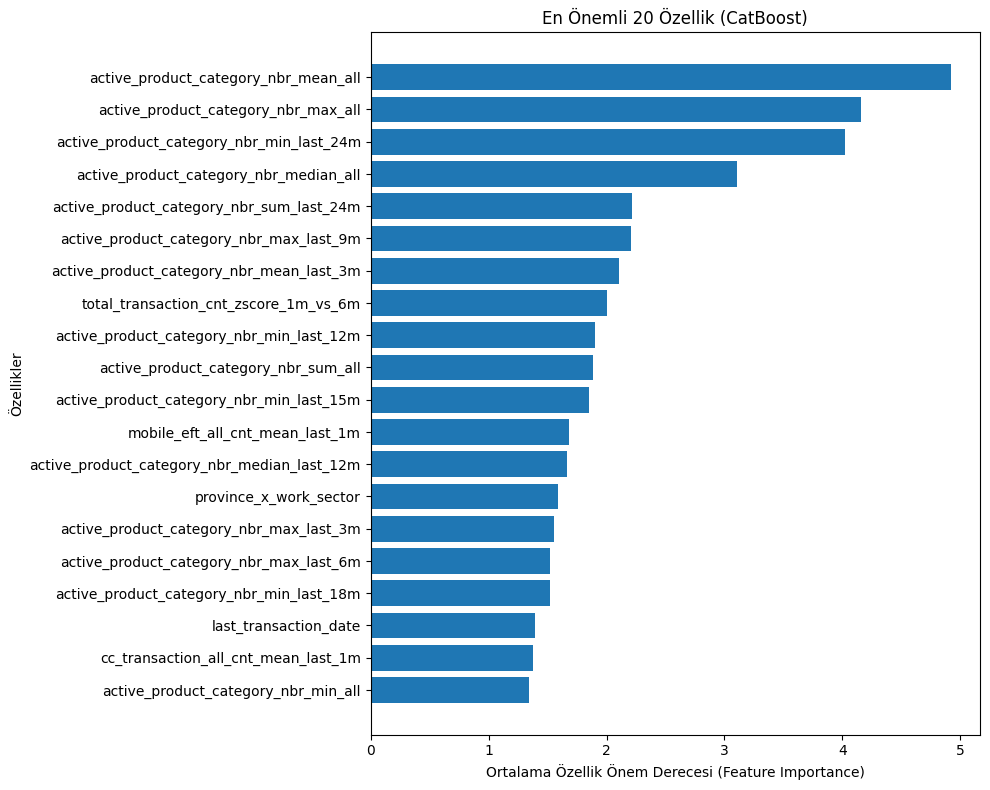


İşlem tamamlandı ve 'submission_catboost_calibrated.csv' dosyası oluşturuldu.

Nihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:
   cust_id     churn
0        1  0.132502
1        2  0.116461
2        9  0.237685
3       15  0.225490
4       19  0.045316


In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import IsotonicRegression
import optuna
import warnings
import gc
import matplotlib.pyplot as plt

# Uyarıları bastır
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Optuna loglamasını açarak her adımı izleyelim
optuna.logging.set_verbosity(optuna.logging.INFO)

# =============================================================================
# YARIŞMA METRİĞİ AYARLARI
# =============================================================================

def recall_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    P = y_true.sum()
    return float(tp_at_k / P) if P > 0 else 0.0

def lift_at_k(y_true, y_prob, k=0.1):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]
    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()
    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0

def convert_auc_to_gini(auc):
    return 2 * auc - 1

def ing_hubs_datathon_metric(y_true, y_prob):
    score_weights = {"gini": 0.4, "recall_at_10perc": 0.3, "lift_at_10perc": 0.3}
    baseline_scores = {"roc_auc": 0.6925726757936908, "recall_at_10perc": 0.18469015795868773, "lift_at_10perc": 1.847159286784029}
    
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        return 0.0
        
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {"roc_auc": roc_auc, "recall_at_10perc": recall_at_10perc, "lift_at_10perc": lift_at_10perc}
    
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])
    
    final_gini_score = new_scores["gini"] / baseline_scores["gini"] if baseline_scores["gini"] != 0 else 0
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"] if baseline_scores["recall_at_10perc"] != 0 else 0
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"] if baseline_scores["lift_at_10perc"] != 0 else 0
    
    final_score = (final_gini_score * score_weights["gini"] + 
                   final_recall_score * score_weights["recall_at_10perc"] + 
                   final_lift_score * score_weights["lift_at_10perc"])
    return final_score

# =============================================================================
# VERİ YÜKLEME VE ÖZELLİK MÜHENDİSLİĞİ
# =============================================================================
def load_data():
    """Tüm CSV dosyalarını yükler."""
    print("Veri setleri yükleniyor...")
    customer_history = pd.read_csv('/kaggle/input/ing-hackathon-data/customer_history.csv', parse_dates=['date'])
    customers = pd.read_csv('/kaggle/input/ing-hackathon-data/customers.csv')
    train_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data.csv', parse_dates=['ref_date'])
    test_ref = pd.read_csv('/kaggle/input/ing-hackathon-data/referance_data_test.csv', parse_dates=['ref_date'])
    sample_submission = pd.read_csv('/kaggle/input/ing-hackathon-data/sample_submission.csv')
    print("Veri setleri başarıyla yüklendi.")
    return customer_history, customers, train_ref, test_ref, sample_submission

def feature_engineering(ref_df, customers_df, history_df, kmeans_model=None, scaler_health=None):
    """Kapsamlı ve birleştirilmiş "ultimate" özellik mühendisliği uygular."""
    print(f"Gelişmiş özellik mühendisliği başlıyor. İşlenecek {len(ref_df)} müşteri var.")
    
    df = pd.merge(ref_df, customers_df, on='cust_id', how='left')
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Student'), 'work_sector'] = 'Student'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Unemployed'), 'work_sector'] = 'Unemployed'
    df.loc[(df['work_sector'].isnull()) & (df['work_type'] == 'Retired'), 'work_sector'] = 'Pension'

    history = pd.merge(df[['cust_id', 'ref_date']], history_df, on='cust_id', how='left')
    history = history[history['date'] <= history['ref_date']].copy()
    
    history['total_transaction_amt'] = history['mobile_eft_all_amt'] + history['cc_transaction_all_amt']
    history['total_transaction_cnt'] = history['mobile_eft_all_cnt'] + history['cc_transaction_all_cnt']
    history['months_before_ref'] = (history['ref_date'].dt.year - history['date'].dt.year) * 12 + (history['ref_date'].dt.month - history['date'].dt.month)

    print("  -> Zaman bazlı agregasyon özellikleri oluşturuluyor...")
    aggs = {}
    cols_to_agg = [
        'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 
        'cc_transaction_all_amt', 'cc_transaction_all_cnt', 'total_transaction_amt', 
        'total_transaction_cnt'
    ]
    stats_to_calc = ['mean', 'sum', 'std', 'min', 'max','median']
    
    for col in cols_to_agg:
        aggs[col] = stats_to_calc
    
    grouped_all = history.groupby('cust_id').agg(aggs)
    grouped_all.columns = ['_'.join(col).strip() + '_all' for col in grouped_all.columns.values]
    df = pd.merge(df, grouped_all, on='cust_id', how='left')
    
    time_windows = [1, 3, 6, 9, 12, 15, 18, 24, 27]
    for window in time_windows:
        period_history = history[history['months_before_ref'] < window]
        grouped_period = period_history.groupby('cust_id').agg(aggs)
        grouped_period.columns = ['_'.join(col).strip() + f'_last_{window}m' for col in grouped_period.columns.values]
        df = pd.merge(df, grouped_period, on='cust_id', how='left')

    print("  -> Büyüme, mevsimsellik ve anomali özellikleri oluşturuluyor...")
    for window in [1, 3, 6, 12]:
        if f'total_transaction_amt_sum_last_{window*2}m' in df.columns:
            df[f'transaction_growth_{window}m'] = (df[f'total_transaction_amt_sum_last_{window}m'] - df[f'total_transaction_amt_sum_last_{window*2}m']) / (df[f'total_transaction_amt_sum_last_{window*2}m'] + 1e-6)

    df['ref_month'] = df['ref_date'].dt.month
    df['ref_quarter'] = df['ref_date'].dt.quarter
    df['is_year_end'] = df['ref_month'].isin([12, 1]).astype(int)

    for col in ['total_transaction_amt', 'total_transaction_cnt']:
        for window in [1,3, 6]:
            mean_col = f'{col}_mean_last_{window}m'
            std_col = f'{col}_std_last_{window}m'
            current_col = f'{col}_sum_last_1m'
            if mean_col in df.columns and std_col in df.columns and current_col in df.columns:
                df[f'{col}_zscore_1m_vs_{window}m'] = (df[current_col] - df[mean_col]) / (df[std_col] + 1e-6)
    
    print("  -> RFM ve diğer davranışsal özellikler ekleniyor...")
    last_transaction = history.groupby('cust_id')['date'].max().reset_index(name='last_transaction_date')
    df = pd.merge(df, last_transaction, on='cust_id', how='left')
    df['days_since_last_transaction'] = (df['ref_date'] - df['last_transaction_date']).dt.days
    
    first_transaction = history.groupby('cust_id')['date'].min().reset_index(name='first_transaction_date')
    df = pd.merge(df, first_transaction, on='cust_id', how='left')

    df['total_months_observed'] = ((df['ref_date'] - df['first_transaction_date']).dt.days / 30.44).round()
    date_nunique = history.groupby('cust_id')['date'].nunique()
    df['date_nunique_all'] = df['cust_id'].map(date_nunique)
    
    df['transaction_frequency_ratio'] = df['date_nunique_all'] / (df['total_months_observed'] + 1e-6)
    df['inactive_months_count'] = df['total_months_observed'] - df['date_nunique_all']
    df['banking_age'] = df['tenure'] - 17
    df['avg_monetary_value_all'] = df['total_transaction_amt_sum_all'] / (df['total_transaction_cnt_sum_all'] + 1e-6)

    rfm_cols = ['days_since_last_transaction', 'transaction_frequency_ratio', 'avg_monetary_value_all']
    rfm_data = df[rfm_cols].fillna(0) 

    if kmeans_model is None:
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df['loyalty_tier'] = kmeans.fit_predict(rfm_data)
        kmeans_model_to_return = kmeans
    else: 
        df['loyalty_tier'] = kmeans_model.predict(rfm_data)
        kmeans_model_to_return = None

    print("  -> Müşteri Sağlık Skoru oluşturuluyor...")
    health_cols = {'pos': ['transaction_frequency_ratio'], 'neg': ['days_since_last_transaction', 'inactive_months_count']}
    health_data = df[health_cols['pos'] + health_cols['neg']].fillna(0)

    if scaler_health is None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        health_scaled = scaler.fit_transform(health_data)
        scaler_health_to_return = scaler
    else:
        health_scaled = scaler_health.transform(health_data)
        scaler_health_to_return = None
    
    health_scaled_df = pd.DataFrame(health_scaled, index=df.index, columns=health_cols['pos'] + health_cols['neg'])
    df['customer_health_score'] = health_scaled_df[health_cols['pos']].sum(axis=1) - health_scaled_df[health_cols['neg']].sum(axis=1)

    bins_age = [17, 30, 45, 65, 120]; labels_age = ['young_adults', 'established_adults', 'prime_age_high_risk', 'senior']
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=True)
    bins_tenure = [-1, 12, 36, 1200]; labels_tenure = ['new_customer', 'loyal_customer', 'veteran_customer']
    df['tenure_group'] = pd.cut(df['tenure'], bins=bins_tenure, labels=labels_tenure, right=True)
    
    df['gender_x_age_group'] = df['gender'].astype(str) + '_' + df['age_group'].astype(str)
    df['tenure_group_x_work_sector'] = df['tenure_group'].astype(str) + '_' + df['work_sector'].astype(str)
    df['province_x_work_sector'] = df['province'].astype(str) + '_' + df['work_sector'].astype(str)
    df['religion_x_age_group'] = df['religion'].astype(str) + '_' + df['age_group'].astype(str)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    cat_cols_final = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    for col in cat_cols_final:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if '-' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('-')
            df[col] = df[col].fillna("-")
        else:
            df[col] = pd.Categorical(df[col].fillna("-"))

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    print(f"Özellik mühendisliği tamamlandı. Toplam {df.shape[1]} özellik oluşturuldu.")
    return df, kmeans_model_to_return, scaler_health_to_return

# =============================================================================
# Model Eğitimi ve Tahmin
# =============================================================================
def optimize_and_train_catboost(train_df, test_df, sample_submission_df, n_trials_optuna=50):
    """Optuna ile optimize edilmiş CatBoost modeli eğitir."""
    print("Nihai CatBoost modeli eğitim süreci başlıyor...")
    
    target = 'churn'
    features_to_drop = ['cust_id', 'ref_date', target]
    original_features = [col for col in train_df.columns if col not in features_to_drop]
    
    cat_cols_initial = [col for col in original_features if train_df[col].dtype == 'object' or isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    num_cols_initial = [col for col in original_features if col not in cat_cols_initial]

    print("  -> Nadir kategoriler 'rare' olarak birleştiriliyor...")
    for col in cat_cols_initial:
        value_counts = train_df[col].value_counts()
        rare_values = value_counts[value_counts < 25].index
        
        if 'rare' not in train_df[col].cat.categories:
            train_df[col] = train_df[col].cat.add_categories('rare')
        if 'rare' not in test_df[col].cat.categories:
            test_df[col] = test_df[col].cat.add_categories('rare')

        train_df[col] = train_df[col].replace(rare_values, 'rare')
        test_df[col] = test_df[col].replace(rare_values, 'rare')

    print("  -> Yüksek korelasyonlu özellikler kaldırılıyor...")
    corr_matrix = train_df[num_cols_initial].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.96)]
    
    train_df = train_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    print(f"    -> {len(to_drop)} özellik kaldırıldı.")
    
    features = [col for col in train_df.columns if col not in features_to_drop]
    cat_cols = [col for col in features if isinstance(train_df[col].dtype, pd.CategoricalDtype)]
    
    # Optuna Objective Function
    def objective(trial):
        params = {
            'iterations': 6000,
            'depth': trial.suggest_int('depth', 5, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'max_bin': trial.suggest_int('max_bin', 32, 128),
            'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
            'allow_writing_files': False,
            'random_state': 0,
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 1.0)
        }
        
        cv_opt = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv_opt.split(train_df, train_df[target]):
            X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
            X_val_fold = train_df.iloc[val_idx].copy()
            
            global_mean_fold = y_train_fold.mean()
            alpha = 5
            for col in cat_cols:
                counts = X_train_fold[col].value_counts()
                means = y_train_fold.groupby(X_train_fold[col]).mean()
                smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
                
                X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
                X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
            
            model = CatBoostClassifier(**params)
            model.fit(X_train_fold[features], y_train_fold,
                      eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                      early_stopping_rounds=100, verbose=0)
            
            preds = model.predict_proba(X_val_fold[features])[:, 1]
            scores.append(ing_hubs_datathon_metric(train_df[target].iloc[val_idx], preds))
        return np.mean(scores)

    print(f"\nOptuna ile optimizasyon başlıyor ({n_trials_optuna} deneme)...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)
    best_params = study.best_params
    print("\nOptimizasyon tamamlandı. En iyi parametreler bulundu:", best_params)

    # Final Model Eğitimi
    final_model_params = {
        'iterations': 6000,
        **best_params 
    }

    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    
    # SHAP için özellik önemlerini topla
    all_fold_importances = []
    
    test_df_encoded = test_df.copy()
    global_mean_full = train_df[target].mean()
    alpha = 5
    for col in cat_cols:
        counts = train_df[col].value_counts()
        means = train_df[target].groupby(train_df[col]).mean()
        smooth_means = (means * counts + global_mean_full * alpha) / (counts + alpha)
        test_df_encoded[col] = test_df_encoded[col].map(smooth_means).astype(float).fillna(global_mean_full)

    print(f"\n7-Fold StratifiedKFold ile eğitim başlıyor...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df[target])):
        print(f"===== Fold {fold+1} =====")
        
        X_train_fold, y_train_fold = train_df.iloc[train_idx].copy(), train_df[target].iloc[train_idx]
        X_val_fold = train_df.iloc[val_idx].copy()
        
        global_mean_fold = y_train_fold.mean()
        for col in cat_cols:
            counts = X_train_fold[col].value_counts()
            means = y_train_fold.groupby(X_train_fold[col]).mean()
            smooth_means = (means * counts + global_mean_fold * alpha) / (counts + alpha)
            
            X_train_fold[col] = X_train_fold[col].map(smooth_means).astype(float)
            X_val_fold[col] = X_val_fold[col].map(smooth_means).astype(float).fillna(global_mean_fold)
        
        model = CatBoostClassifier(**final_model_params)
        model.fit(X_train_fold[features], y_train_fold,
                  eval_set=(X_val_fold[features], train_df[target].iloc[val_idx]),
                  early_stopping_rounds=40,
                  verbose=500)
        
        oof_preds[val_idx] = model.predict_proba(X_val_fold[features])[:, 1]
        test_preds += model.predict_proba(test_df_encoded[features])[:, 1] / cv.n_splits
        all_fold_importances.append(model.get_feature_importance())
        
        del X_train_fold, y_train_fold, X_val_fold
        gc.collect()

    final_oof_score = ing_hubs_datathon_metric(train_df[target], oof_preds)
    print("\n==============================================")
    print(f"Final OOF Skoru (Kalibrasyon Öncesi): {final_oof_score:.5f}")
    
    print("  -> Olasılık kalibrasyonu uygulanıyor...")
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(oof_preds, train_df[target])
    calibrated_test_preds = iso_reg.transform(test_preds)

    calibrated_oof_score = ing_hubs_datathon_metric(train_df[target], iso_reg.transform(oof_preds))
    print(f"Final OOF Skoru (Kalibrasyon Sonrası): {calibrated_oof_score:.5f}")
    print("==============================================")
    
    # SHAP Özet Grafiği
    print("\nSHAP Değerleri Hesaplanıyor ve Grafik Çiziliyor...")
    mean_importances = np.mean(all_fold_importances, axis=0)
    importance_df = pd.DataFrame({'feature': features, 'importance': mean_importances})
    importance_df = importance_df.sort_values(by='importance', ascending=False).head(150)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel("Ortalama Özellik Önem Derecesi (Feature Importance)")
    plt.ylabel("Özellikler")
    plt.title("En Önemli 20 Özellik (CatBoost)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    submission_df = sample_submission_df.copy()
    submission_df['churn'] = calibrated_test_preds
    submission_df.to_csv('submission_catboost_calibrated.csv', index=False)
    
    print("\nİşlem tamamlandı ve 'submission_catboost_calibrated.csv' dosyası oluşturuldu.")
    return submission_df

# =============================================================================
# Ana Çalıştırma Bloğu
# =============================================================================
if __name__ == "__main__":
    customer_history, customers, train_ref, test_ref, sample_submission = load_data()
    
    train_featured, kmeans_model, scaler_health = feature_engineering(train_ref, customers, customer_history)
    test_featured, _, _ = feature_engineering(test_ref, customers, customer_history, kmeans_model=kmeans_model, scaler_health=scaler_health)
    
    del customer_history, customers, train_ref, test_ref
    gc.collect()

    submission = optimize_and_train_catboost(train_featured, test_featured, sample_submission, n_trials_optuna=100)
    
    print("\nNihai işlem tamamlandı. Gönderim dosyasının ilk 5 satırı:")
    print(submission.head())